# Permutation score analysis
In this notebook we want to compare the Nuc/Cyt model with the original veloVI model solely trained on either snRNA or scRNA data based on permutation scores. In this notebook we use the integrated data of the trained `scglue` model to estimate abundances and for calculations where we require a neighbor graph.


**Requires:**
- `sn_sc_rna_scglue.h5ad`

   (Notebook: `/notebooks/integration_imputation/scglue_gex_integration.ipynb`)
- `pancreas_multiome/processed/gex_e14.5.h5ad`

   (Notebook: `/notebooks/data_preprocessing/sn_rna_preprocess_pancreas.ipynb`)
- `pancreas_sc/processed/gex_e14.5.h5ad`

   (Notebook: `/notebooks/data_preprocessing/sc_rna_preprocess_pancreas.ipynb`)

**Output:**
This notebook will output different plots if `SAVE_FIGURES=TRUE`

## Library imports

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys

import joypy
import mplscience
import torch
from velovi import VELOVI

import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import scvelo as scv
from scvelo.inference import fit_velovi
from scvelo.plotting.simulation import compute_dynamics

sys.path.append("../..")
from paths import PROJECT_DIR, FIG_DIR  # isort: skip  # noqa: E402

/vol/storage/miniconda3/envs/conda_env_robin/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/vol/storage/miniconda3/envs/conda_env_robin/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/vol/storage/miniconda3/envs/conda_env_robin/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-

## General settings

In [4]:
SAVE_FIGURES = True

sns.reset_defaults()
sns.reset_orig()
scv.settings.set_figure_params("scvelo", dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map="viridis")

celltype_colors = {
    "Alpha": "#1f78b4",
    "Beta": "#b2df8a",
    "Delta": "#6a3d9a",
    "Ductal": "#8fbc8f",
    "Epsilon": "#cab2d6",
    "Ngn3 high EP": "#fdbf6f",
    "Ngn3 low EP": "#f4a460",
    "Pre-endocrine": "#ff7f00",
}

## Function Defintions

In [5]:
def plot_perm_scores(adata, perm_scores, gene, color_label, figsize=(6, 4), save_figure=SAVE_FIGURES, path=None):
    """Plots the permutation score as barplot of a gene.

    Parameters
    ----------
    adata
        Annotated data
    perm_scores
        Annotated data object 2
    gene
        Name of gene as string
    color_label
        Color, e.g. 'celltype' needs to be present in `adata.obs`
    figsize
        Size of figure
    """
    df = pd.DataFrame(perm_scores.loc[gene])
    df["Cell type"] = df.index
    order = adata.obs[color_label].cat.categories.tolist().sort()

    with mplscience.style_context():
        sns.set_style(style="whitegrid")
        fig, ax = plt.subplots(figsize=figsize)
        sns.barplot(
            data=df,
            y=gene,
            x="Cell type",
            palette=adata.uns[f"{color_label}_colors"],
            order=order,
            ax=ax,
        )
        ax.set_ylim([-3.5, 15])
        ax.tick_params(axis="x", rotation=45)
        if SAVE_FIGURES:
            fig.savefig(
                path,
                format="svg",
                transparent=True,
                bbox_inches="tight",
            )


def fit_velovi_(bdata):
    """Training function for original veloVI model for scRNA or snRNA data.

    Parameters
    ----------
    bdata
        Annotated data
    """
    VELOVI.setup_anndata(bdata, spliced_layer="Ms", unspliced_layer="Mu")

    vae = VELOVI(bdata)
    vae.train(max_epochs=500)

    latent_time = vae.get_latent_time(n_samples=25)
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)

    bdata.layers["velocities_velovi"] = velocities / scaling
    bdata.layers["latent_time_velovi"] = latent_time

    bdata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    bdata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    bdata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    bdata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr).detach().cpu().numpy()
    ) * scaling
    bdata.layers["fit_t"] = latent_time.values * np.expand_dims(scaling, axis=0)
    bdata.var["fit_scaling"] = scaling

    return vae, bdata


def plot_dynamics_(adata, gene, color, ax):
    """Plots inferred dynamics for original RNA velo model.

    Parameters
    ----------
    adata
        Annotated data
    gene
        Name of gene
    color
        Color for plotting dynamics
    ax
        Axis
    """
    with mplscience.style_context():
        _, unspliced, spliced = compute_dynamics(adata, basis=gene, extrapolate=True, sort=True)
        ax.plot(spliced, unspliced, color=color, linewidth=2)

        spliced_steady_state = np.linspace(np.min(spliced), np.max(spliced))
        unspliced_steady_state = adata.var.loc[gene, "fit_gamma"] / adata.var.loc[gene, "fit_beta"] * (
            spliced_steady_state - np.min(spliced_steady_state)
        ) + np.min(unspliced)
        ax.plot(spliced_steady_state, unspliced_steady_state, color=color, linestyle="--", linewidth=2)

In [6]:
def _add_significance(ax, left: int, right: int, significance: str, level: int = 0, **kwargs):
    bracket_level = kwargs.pop("bracket_level", 1)
    bracket_height = kwargs.pop("bracket_height", 0.02)
    text_height = kwargs.pop("text_height", 0.01)

    bottom, top = ax.get_ylim()
    y_axis_range = top - bottom

    bracket_level = (y_axis_range * 0.07 * level) + top * bracket_level
    bracket_height = bracket_level - (y_axis_range * bracket_height)

    ax.plot([left, left, right, right], [bracket_height, bracket_level, bracket_level, bracket_height], **kwargs)

    ax.text(
        (left + right) * 0.5,
        bracket_level + (y_axis_range * text_height),
        significance,
        ha="center",
        va="bottom",
        c="k",
    )

In [7]:
def _get_significance(pvalue):
    if pvalue < 0.001:
        return "***"
    elif pvalue < 0.01:
        return "**"
    elif pvalue < 0.1:
        return "*"
    else:
        return "n.s."

## Read and preprocess multi-modal Data


In [9]:
adata = sc.read(PROJECT_DIR / "pancreas_sc_multiome" / "sn_sc_rna_scglue_e15.5.h5ad")

## Preprocess snRNA, scRNA data for later comparison

In [10]:
adata_sc = sc.read(PROJECT_DIR / "pancreas_sc" / "processed" / "gex_e15.5.h5ad")
adata_sn = sc.read(PROJECT_DIR / "pancreas_multiome" / "processed" / "gex_e15.5.h5ad")

# extract highly variable genes and normalize count data
scv.pp.filter_and_normalize(adata_sc, min_counts=20, n_top_genes=2000)
scv.pp.filter_and_normalize(adata_sn, min_counts=20, n_top_genes=2000)

# calculate neighbor graphs
scv.pp.neighbors(adata_sn)
scv.pp.neighbors(adata_sc)

# snRNA
scv.pp.moments(
    adata_sn,
    use_rep="X_pca",
)

scaler = MinMaxScaler()
adata_sn.layers["Mu"] = scaler.fit_transform(adata_sn.layers["Mu"])

scaler = MinMaxScaler()
adata_sn.layers["Ms"] = scaler.fit_transform(adata_sn.layers["Ms"])

## scRNA
scv.pp.moments(
    adata_sc,
    use_rep="X_pca",
)

scaler = MinMaxScaler()
adata_sc.layers["Mu"] = scaler.fit_transform(adata_sc.layers["Mu"])

scaler = MinMaxScaler()
adata_sc.layers["Ms"] = scaler.fit_transform(adata_sc.layers["Ms"])

Filtered out 4081 genes that are detected 20 counts (spliced).
Normalized count data: spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
Filtered out 1422 genes that are detected 20 counts (spliced).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    ['Ms', 'Mu'] moments of un/spliced abundances (adata.layers)
computing moments based on connectivities
    finished (0:00:00) --> added 
    ['Ms', 'Mu'] moments of un/spliced abundances (adata.layers)


## Fit veloVI Nucleus/ Cytosol Model
Note that we decrease the lr compared to original veloVI, as we might run into NaN issues when inferring mean, var for latent representation

In [11]:
vae, adata = fit_velovi(
    adata, max_epochs=500, unspliced_layer_nuc="Mu_nuc", spliced_layer_nuc="Ms_nuc", spliced_layer_cyt="Ms_cyt", lr=5e-3
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|████| 500/500 [12:17<00:00,  1.32s/it, v_num=1, train_loss_step=-1.47e+4, train_loss_epoch=-1.47e+4]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|████| 500/500 [12:17<00:00,  1.47s/it, v_num=1, train_loss_step=-1.47e+4, train_loss_epoch=-1.47e+4]


#### Plot losses

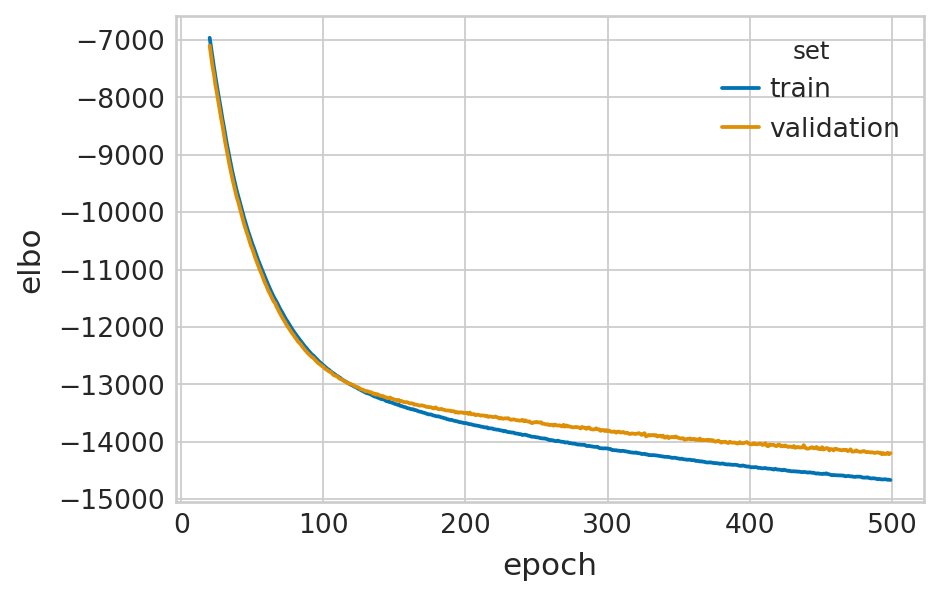

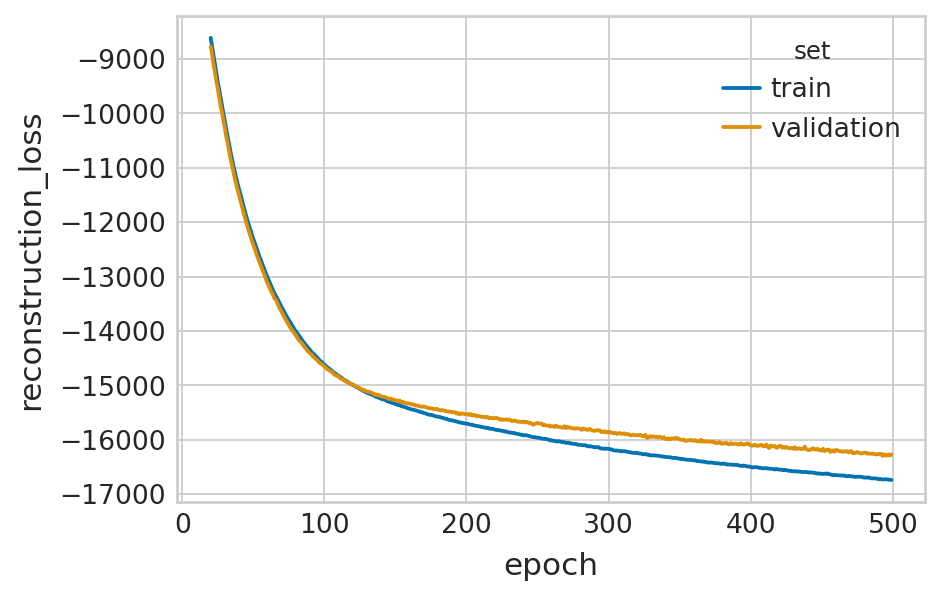

In [12]:
df = vae.history["elbo_train"].iloc[20:].reset_index().rename(columns={"elbo_train": "elbo"})
df["set"] = "train"

_df = vae.history["elbo_validation"].iloc[20:].reset_index().rename(columns={"elbo_validation": "elbo"})
_df["set"] = "validation"

df = pd.concat([df, _df], axis=0).reset_index(drop=True)

with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.lineplot(data=df, x="epoch", y="elbo", hue="set", palette=["#0173B2", "#DE8F05"], ax=ax)
    plt.show()

df = (
    vae.history["reconstruction_loss_train"]
    .iloc[20:]
    .reset_index()
    .rename(columns={"reconstruction_loss_train": "reconstruction_loss"})
)
df["set"] = "train"

_df = (
    vae.history["reconstruction_loss_validation"]
    .iloc[20:]
    .reset_index()
    .rename(columns={"reconstruction_loss_validation": "reconstruction_loss"})
)
_df["set"] = "validation"

df = pd.concat([df, _df], axis=0).reset_index(drop=True)

with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.lineplot(data=df, x="epoch", y="reconstruction_loss", hue="set", palette=["#0173B2", "#DE8F05"], ax=ax)
    plt.show()

## Fit original veloVI model on scRNA-seq data

In [13]:
vae_sc, adata_sc = fit_velovi_(adata_sc)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|████| 500/500 [03:55<00:00,  2.08it/s, v_num=1, train_loss_step=-9.04e+3, train_loss_epoch=-9.16e+3]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|████| 500/500 [03:55<00:00,  2.12it/s, v_num=1, train_loss_step=-9.04e+3, train_loss_epoch=-9.16e+3]


#### Plot losses

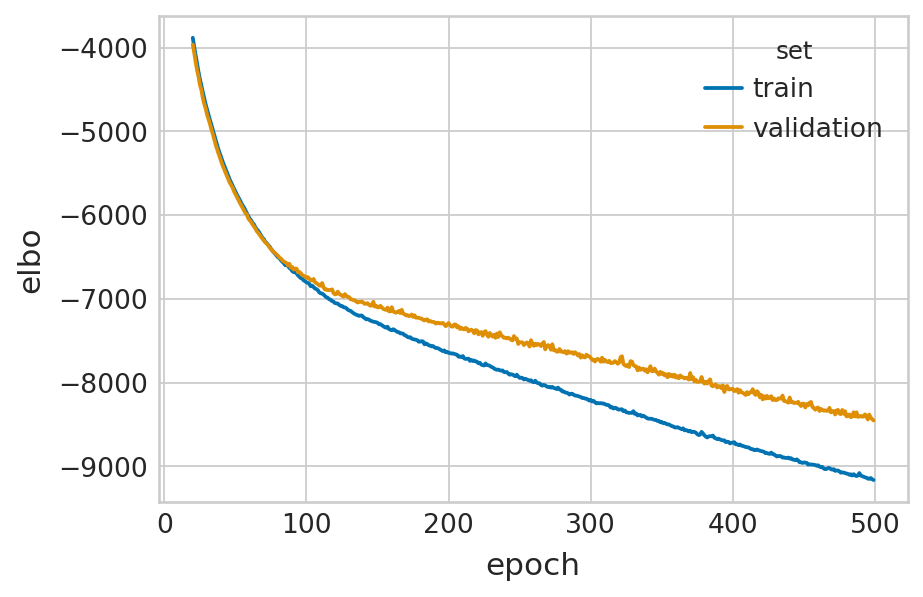

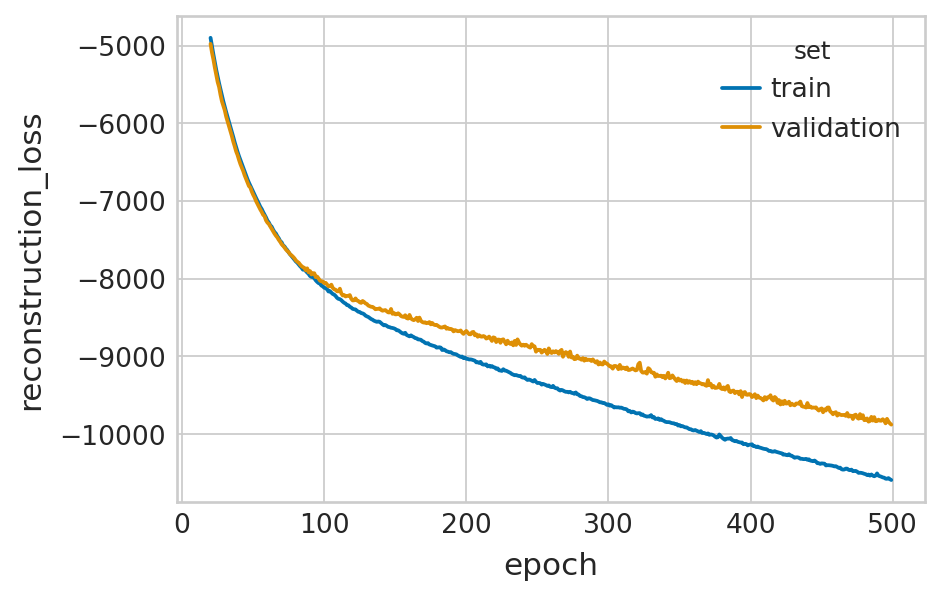

In [14]:
df = vae_sc.history["elbo_train"].iloc[20:].reset_index().rename(columns={"elbo_train": "elbo"})
df["set"] = "train"

_df = vae_sc.history["elbo_validation"].iloc[20:].reset_index().rename(columns={"elbo_validation": "elbo"})
_df["set"] = "validation"

df = pd.concat([df, _df], axis=0).reset_index(drop=True)

with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.lineplot(data=df, x="epoch", y="elbo", hue="set", palette=["#0173B2", "#DE8F05"], ax=ax)
    plt.show()

df = (
    vae_sc.history["reconstruction_loss_train"]
    .iloc[20:]
    .reset_index()
    .rename(columns={"reconstruction_loss_train": "reconstruction_loss"})
)
df["set"] = "train"

_df = (
    vae_sc.history["reconstruction_loss_validation"]
    .iloc[20:]
    .reset_index()
    .rename(columns={"reconstruction_loss_validation": "reconstruction_loss"})
)
_df["set"] = "validation"

df = pd.concat([df, _df], axis=0).reset_index(drop=True)

with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.lineplot(data=df, x="epoch", y="reconstruction_loss", hue="set", palette=["#0173B2", "#DE8F05"], ax=ax)
    plt.show()

## Fit original veloVI model just on snRNA-seq data

In [15]:
vae_sn, adata_sn = fit_velovi_(adata_sn)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|█████| 500/500 [05:05<00:00,  1.63it/s, v_num=1, train_loss_step=-6.14e+3, train_loss_epoch=-6.2e+3]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|█████| 500/500 [05:05<00:00,  1.64it/s, v_num=1, train_loss_step=-6.14e+3, train_loss_epoch=-6.2e+3]


#### Plot losses

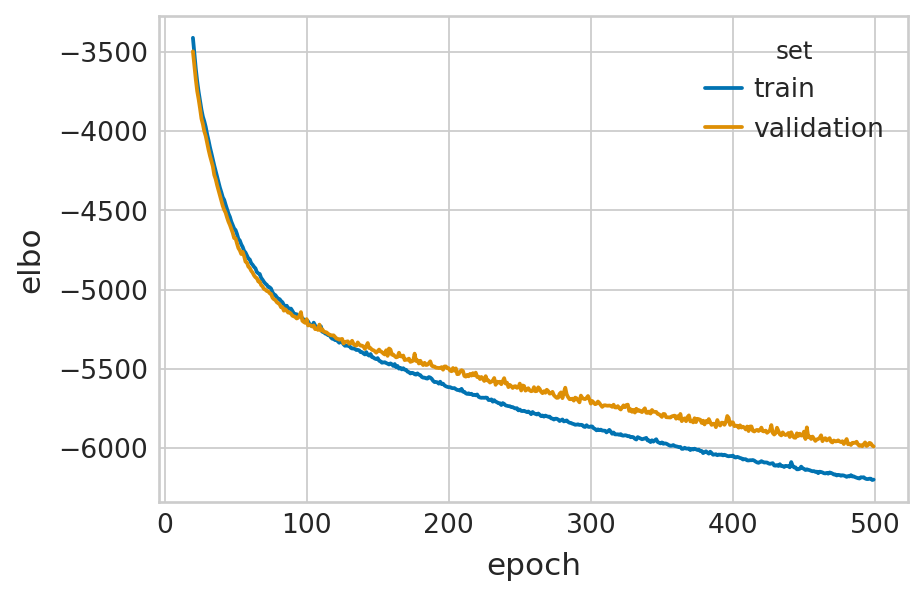

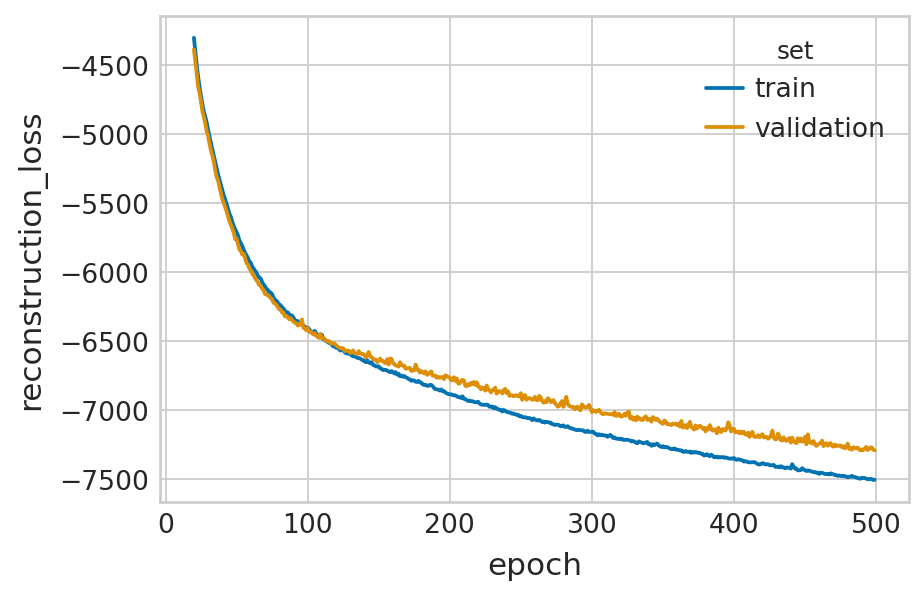

In [16]:
df = vae_sn.history["elbo_train"].iloc[20:].reset_index().rename(columns={"elbo_train": "elbo"})
df["set"] = "train"

_df = vae_sn.history["elbo_validation"].iloc[20:].reset_index().rename(columns={"elbo_validation": "elbo"})
_df["set"] = "validation"

df = pd.concat([df, _df], axis=0).reset_index(drop=True)

with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.lineplot(data=df, x="epoch", y="elbo", hue="set", palette=["#0173B2", "#DE8F05"], ax=ax)
    plt.show()

df = (
    vae_sn.history["reconstruction_loss_train"]
    .iloc[20:]
    .reset_index()
    .rename(columns={"reconstruction_loss_train": "reconstruction_loss"})
)
df["set"] = "train"

_df = (
    vae_sn.history["reconstruction_loss_validation"]
    .iloc[20:]
    .reset_index()
    .rename(columns={"reconstruction_loss_validation": "reconstruction_loss"})
)
_df["set"] = "validation"

df = pd.concat([df, _df], axis=0).reset_index(drop=True)

with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.lineplot(data=df, x="epoch", y="reconstruction_loss", hue="set", palette=["#0173B2", "#DE8F05"], ax=ax)
    plt.show()

## Permutation score evaluation

In [17]:
adata.uns["celltype_colors"] = celltype_colors
adata_sc.uns["celltype_colors"] = celltype_colors
adata_sn.uns["celltype_colors"] = celltype_colors

In [18]:
perm_scores, permuted_adata = vae.get_permutation_scores(labels_key="celltype")
perm_scores_sc, permuted_adata_sc = vae_sc.get_permutation_scores(labels_key="celltype")
perm_scores_sn, permuted_adata_sn = vae_sn.get_permutation_scores(labels_key="celltype")

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [19]:
# Select common genes from 3 adatas
common_genes = list(set(perm_scores.index).intersection(perm_scores_sn.index).intersection(perm_scores_sc.index))

perm_scores_common = perm_scores.loc[common_genes]
perm_scores_sc_common = perm_scores_sc.loc[common_genes]
perm_scores_sn_common = perm_scores_sn.loc[common_genes]

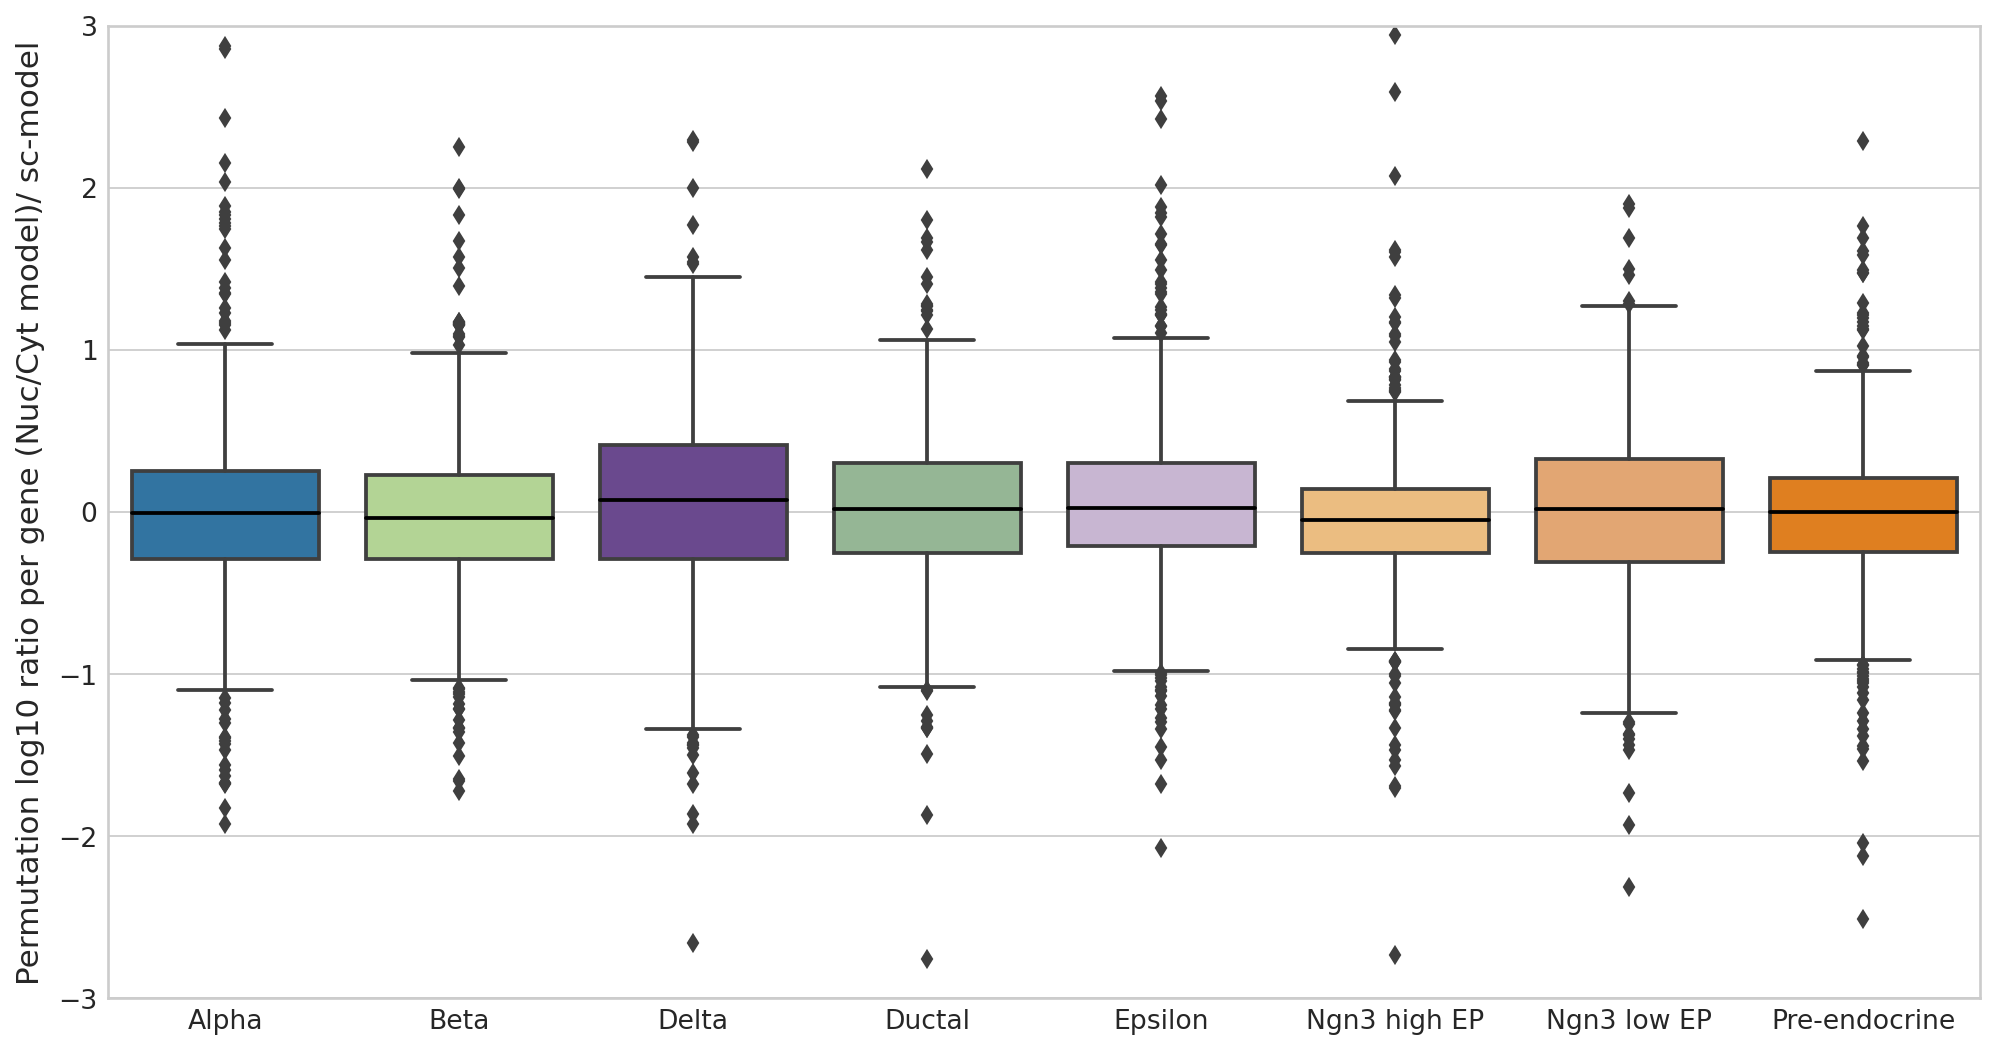

In [20]:
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(15, 8))
    sns.boxplot(
        data=np.log10(perm_scores_common / perm_scores_sc_common),
        palette=adata.uns["celltype_colors"],
        medianprops={"color": "black"},
    )
    ax.set_ylim([-3, 3])
    ax.set_ylabel("Permutation log10 ratio per gene (Nuc/Cyt model)/ sc-model")
    plt.show()

if SAVE_FIGURES:
    path = FIG_DIR / "permutation_scores"
    if not os.path.exists(path):
        path.mkdir()
    fig.savefig(path / "permutation_snsc_vs_sc_e15.svg", format="svg", transparent=True, bbox_inches="tight")

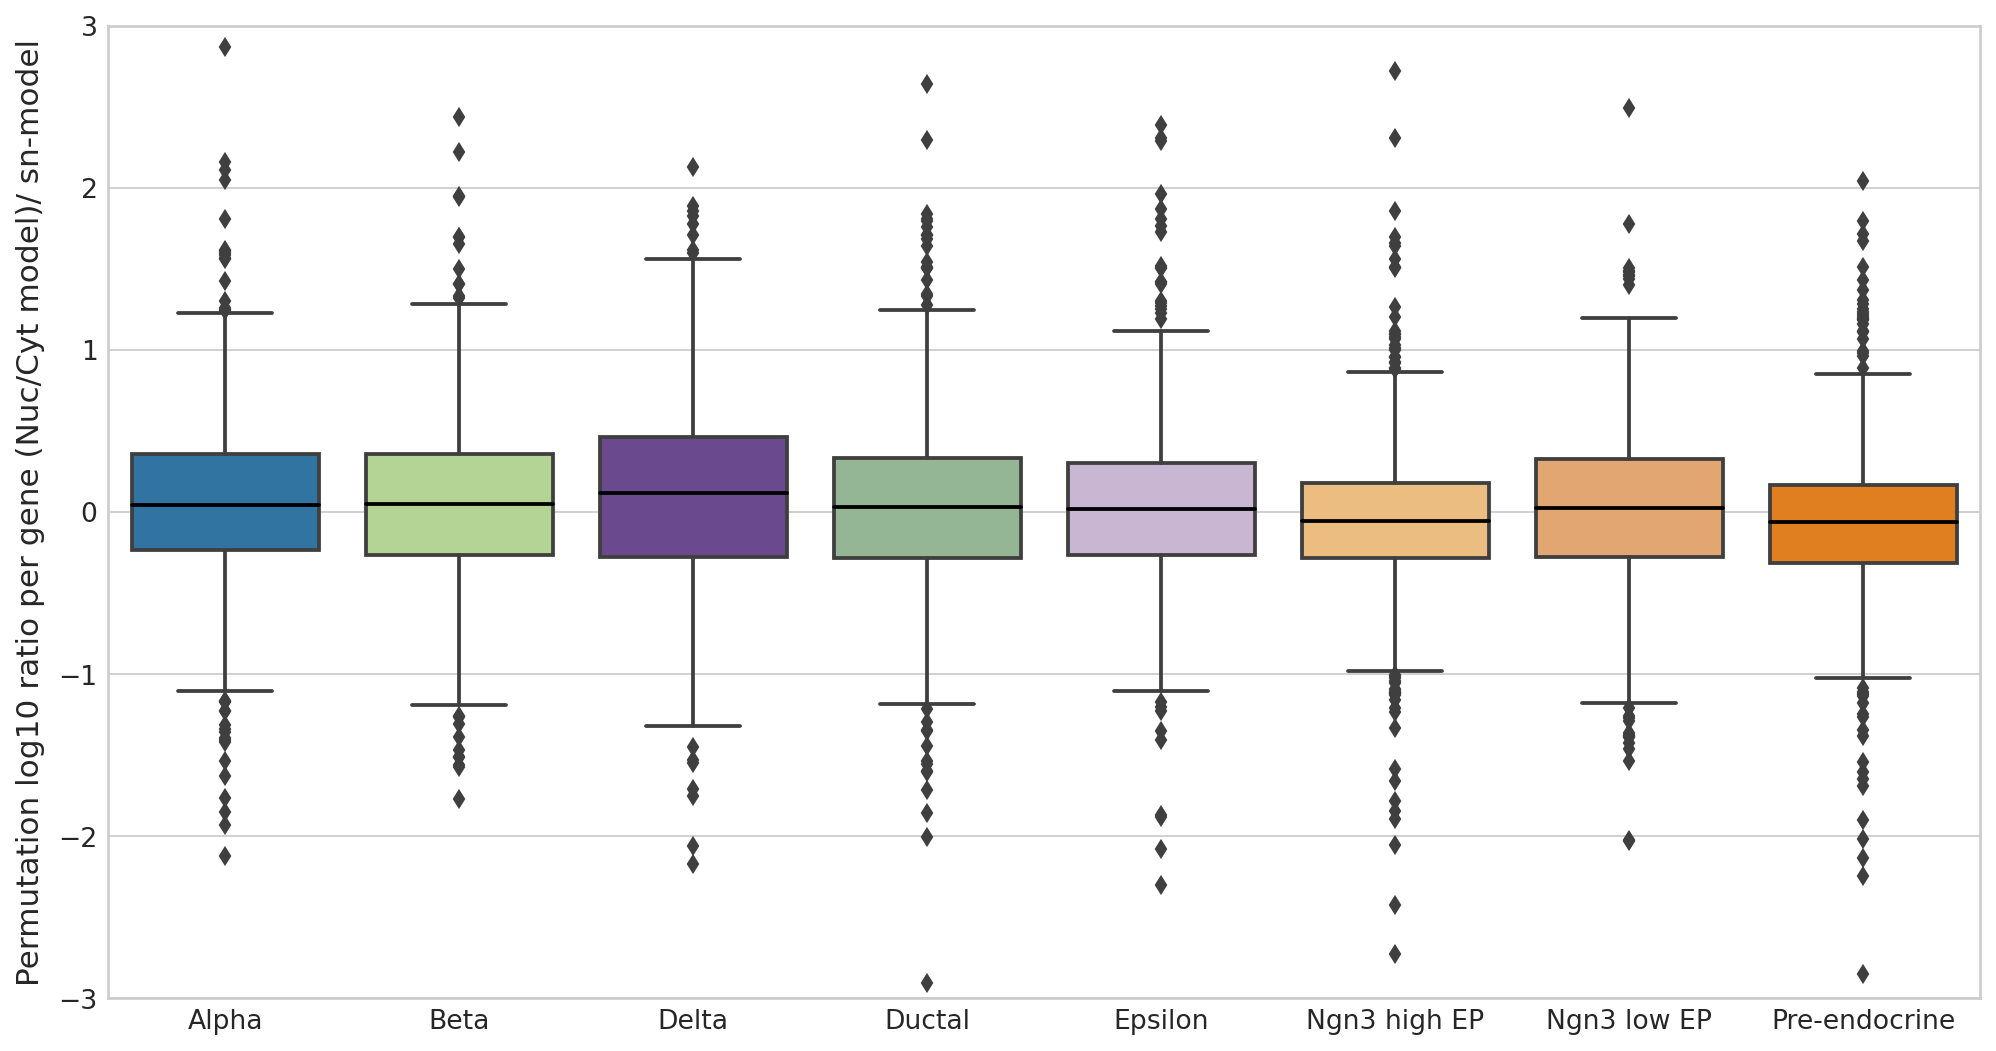

In [21]:
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(15, 8))
    sns.boxplot(
        data=np.log10(perm_scores_common / perm_scores_sn_common),
        palette=adata.uns["celltype_colors"],
        medianprops={"color": "black"},
    )
    ax.set_ylim([-3, 3])
    ax.set_ylabel("Permutation log10 ratio per gene (Nuc/Cyt model)/ sn-model")
    plt.show()

if SAVE_FIGURES:
    path = FIG_DIR / "permutation_scores"
    if not os.path.exists(path):
        path.mkdir()
    fig.savefig(path / "permutation_snsc_vs_sn_e15.svg", format="svg", transparent=True, bbox_inches="tight")

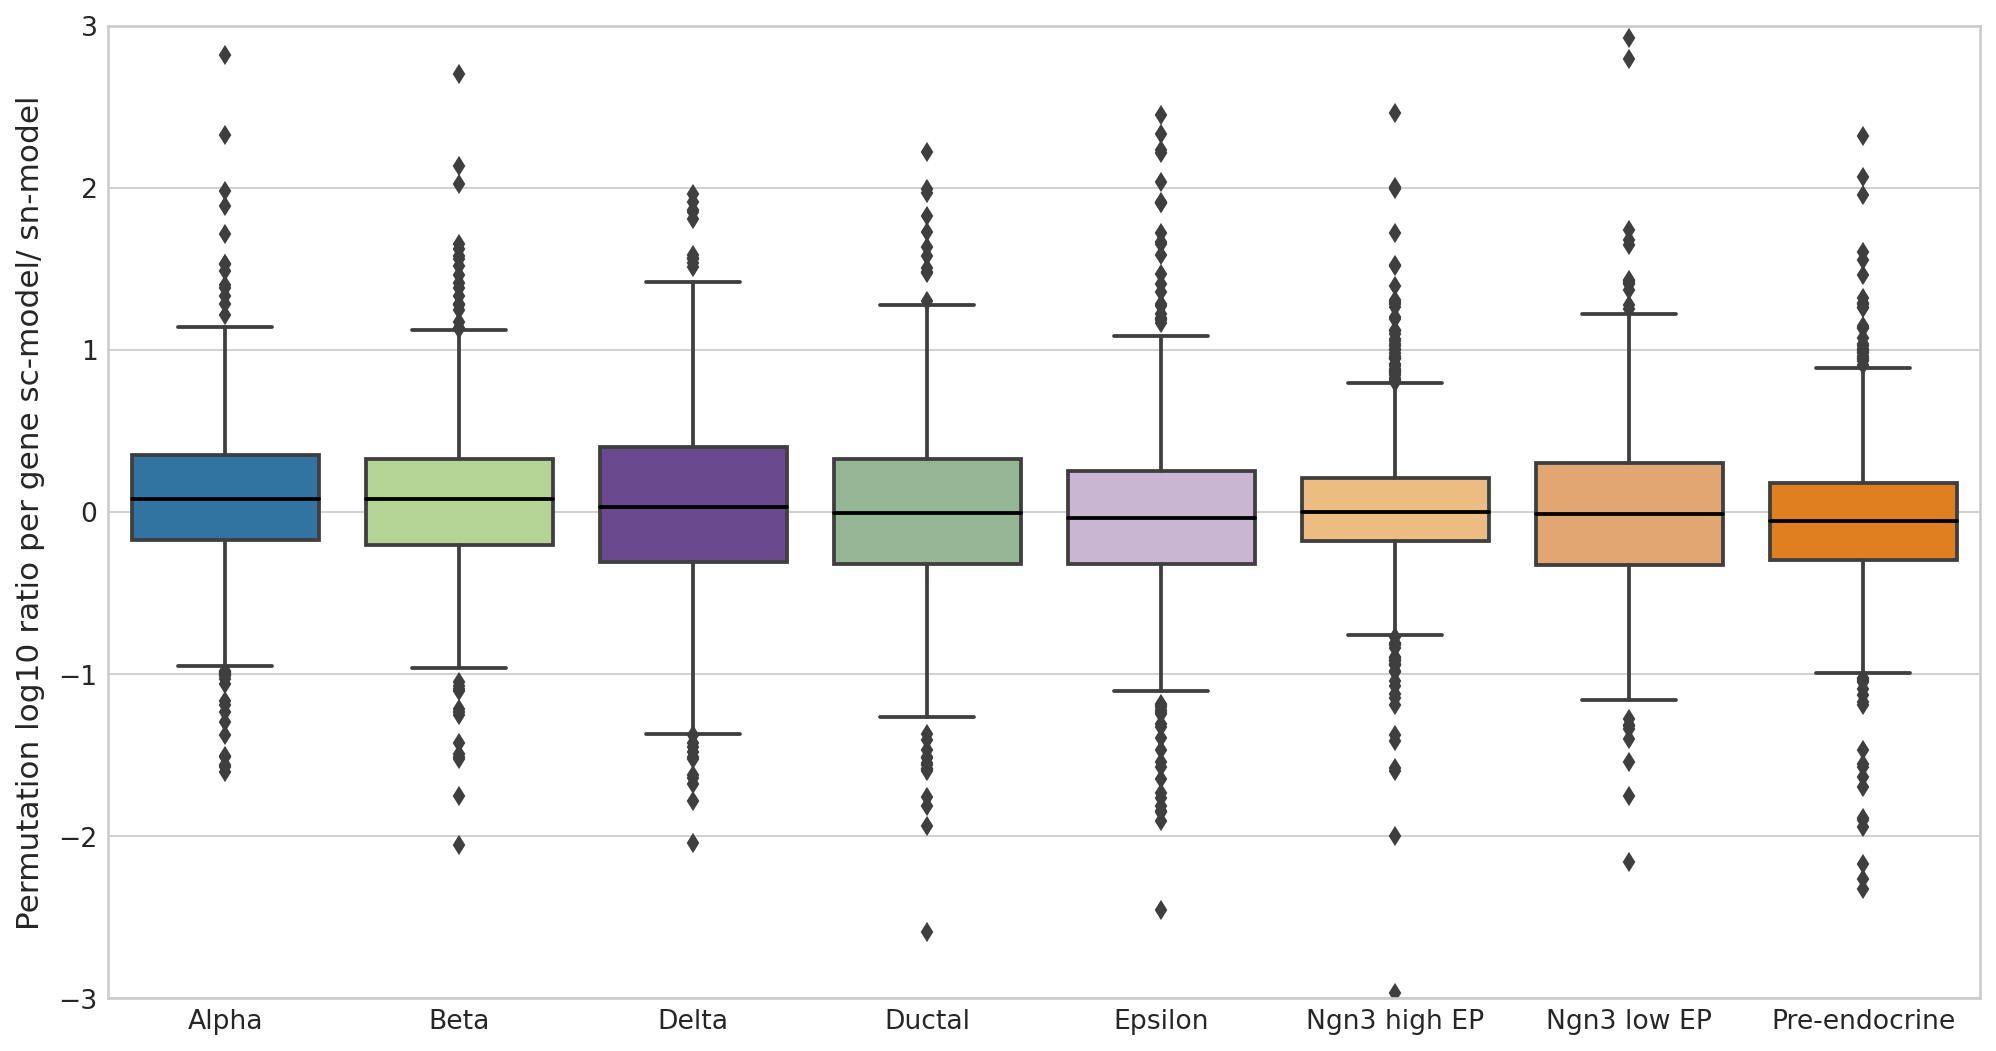

In [22]:
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(15, 8))
    sns.boxplot(
        data=np.log10(perm_scores_sc_common / perm_scores_sn_common),
        palette=adata.uns["celltype_colors"],
        medianprops={"color": "black"},
    )
    ax.set_ylim([-3, 3])
    ax.set_ylabel("Permutation log10 ratio per gene sc-model/ sn-model")
    plt.show()

if SAVE_FIGURES:
    path = FIG_DIR / "permutation_scores"
    if not os.path.exists(path):
        path.mkdir()
    fig.savefig(path / "permutation_sc_vs_sn_e15.svg", format="svg", transparent=True, bbox_inches="tight")

## Plot permutation distribution

In [23]:
full_perm_df = pd.DataFrame(columns=["Score", "Model"])
perm_dfs = [perm_scores_common, perm_scores_sc_common, perm_scores_sn_common]
names = ["Nuc/Cyt model", "sc-model", "sn-model"]
models = []
scores = []
for perm_df, model_name in zip(perm_dfs, names):
    p = perm_df.values
    # select perm score of celltype with highest value
    max_ratio = np.nanmax(p, axis=1)
    scores += max_ratio.tolist()
    models += len(max_ratio) * [model_name]
full_perm_df["Score"] = scores
full_perm_df["Model"] = models

n_datasets = 4

full_perm_df["Model_id"] = full_perm_df["Model"].replace(dict(zip(names, range(len(names)))))

palette = dict(zip(full_perm_df["Model"].unique(), sns.color_palette("colorblind").as_hex()[:n_datasets]))

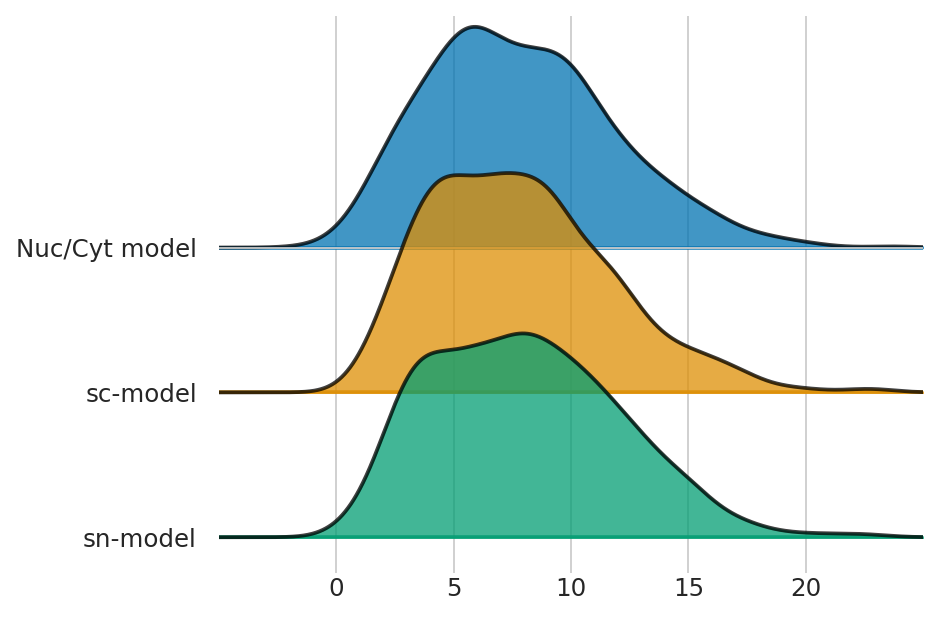

In [24]:
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, axes = joypy.joyplot(
        full_perm_df,
        by="Model_id",
        color=[palette[model] for model in names],
        alpha=0.75,
        labels=names,
        x_range=[-5, 25],
        figsize=(6, 4),
        grid="both",
    )
    if SAVE_FIGURES:
        path = FIG_DIR / "permutation_scores" / "perm_scores"
        path.mkdir(parents=True, exist_ok=True)
        fig.savefig(path / "permscores_joyplot_e15.svg", format="svg", transparent=True, bbox_inches="tight")

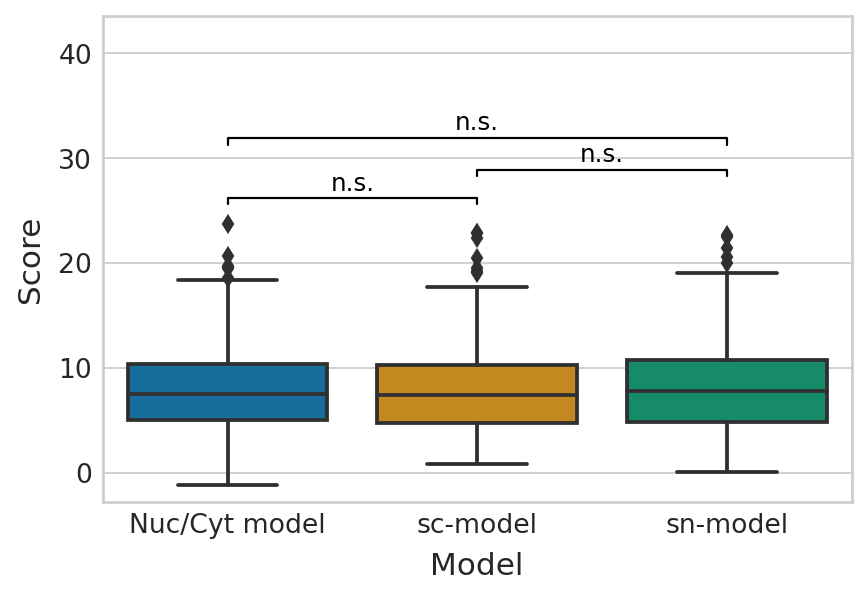

In [40]:
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(6, 4))

    sns.boxplot(data=full_perm_df, x="Model", y="Score", palette="colorblind", ax=ax)

    # sc vs nuc cyt
    ttest_res = ttest_ind(
        full_perm_df.loc[full_perm_df.Model == "Nuc/Cyt model", "Score"],
        full_perm_df.loc[full_perm_df.Model == "sc-model", "Score"],
        equal_var=False,
        alternative="two-sided",
    )
    significance = _get_significance(ttest_res.pvalue)
    _add_significance(
        ax=ax,
        left=0,
        right=1,
        significance=significance,
        lw=1,
        bracket_level=1.05,
        c="k",
        level=0,
    )
    # sc vs sn
    ttest_res = ttest_ind(
        full_perm_df.loc[full_perm_df.Model == "sc-model", "Score"],
        full_perm_df.loc[full_perm_df.Model == "sn-model", "Score"],
        equal_var=False,
        alternative="two-sided",
    )
    significance = _get_significance(ttest_res.pvalue)
    _add_significance(
        ax=ax,
        left=1,
        right=2,
        significance=significance,
        lw=1,
        bracket_level=1.05,
        c="k",
        level=0,
    )
    # Nuc cyt cs sn model
    ttest_res = ttest_ind(
        full_perm_df.loc[full_perm_df.Model == "Nuc/Cyt model", "Score"],
        full_perm_df.loc[full_perm_df.Model == "sn-model", "Score"],
        equal_var=False,
        alternative="two-sided",
    )
    significance = _get_significance(ttest_res.pvalue)
    _add_significance(
        ax=ax,
        left=0,
        right=2,
        significance=significance,
        lw=1,
        bracket_level=1.05,
        c="k",
        level=0,
    )

    ax.set_ylim([ax.get_ylim()[0], ax.get_ylim()[1] + 10])
    if SAVE_FIGURES:
        path = FIG_DIR / "permutation_scores" / "perm_scores"
        path.mkdir(parents=True, exist_ok=True)
        fig.savefig(path / "permscores_boxplot_e15.svg", format="svg", transparent=True, bbox_inches="tight")

## Plot phase portraits for Top2a, Sulf2, Hells

### 1. Spliced Cytoplasm vs. Spliced Nucleus

In [29]:
plot_genes = ["Top2a", "Sulf2", "Hells"]

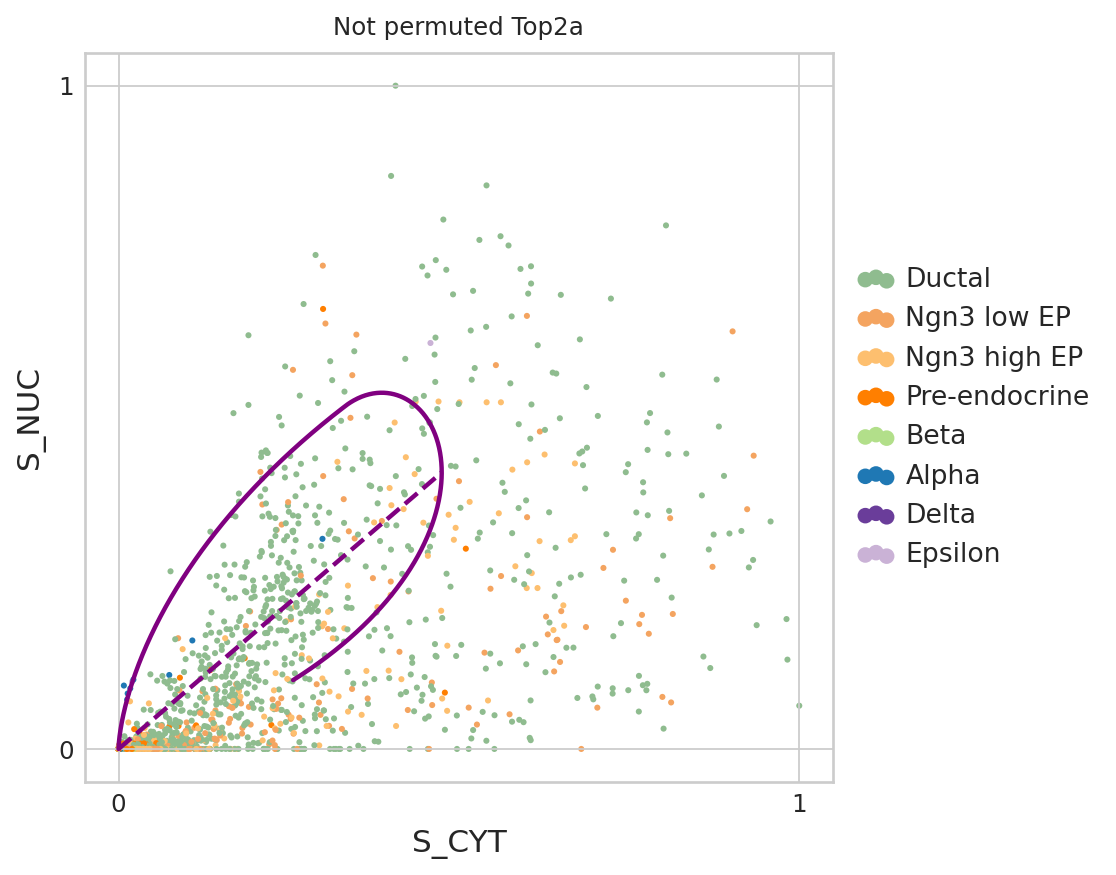

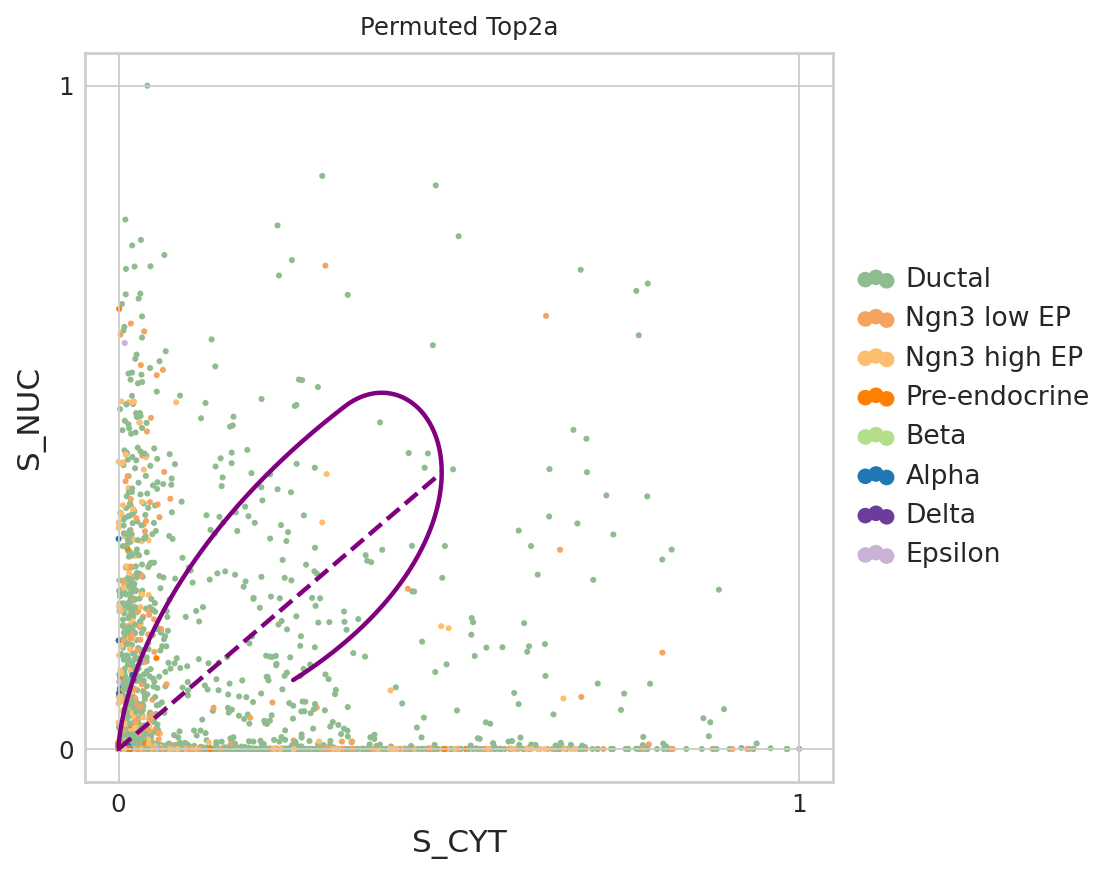

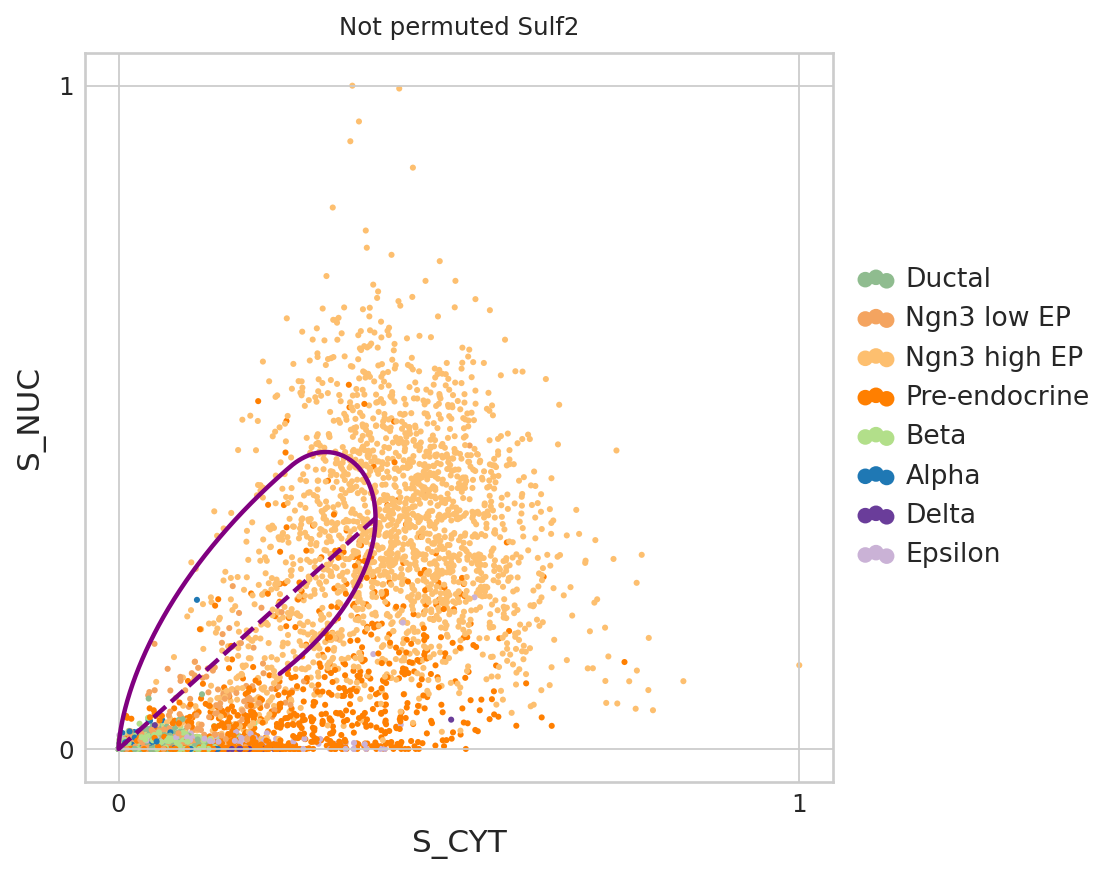

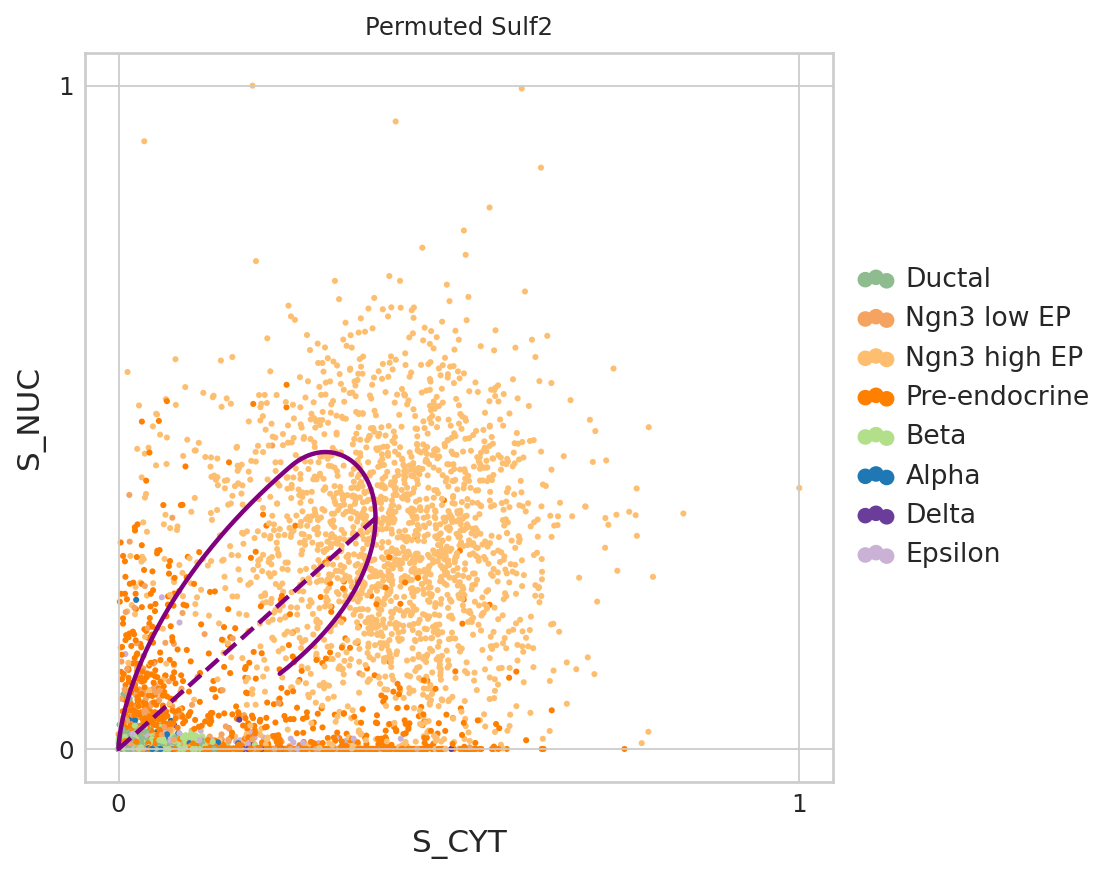

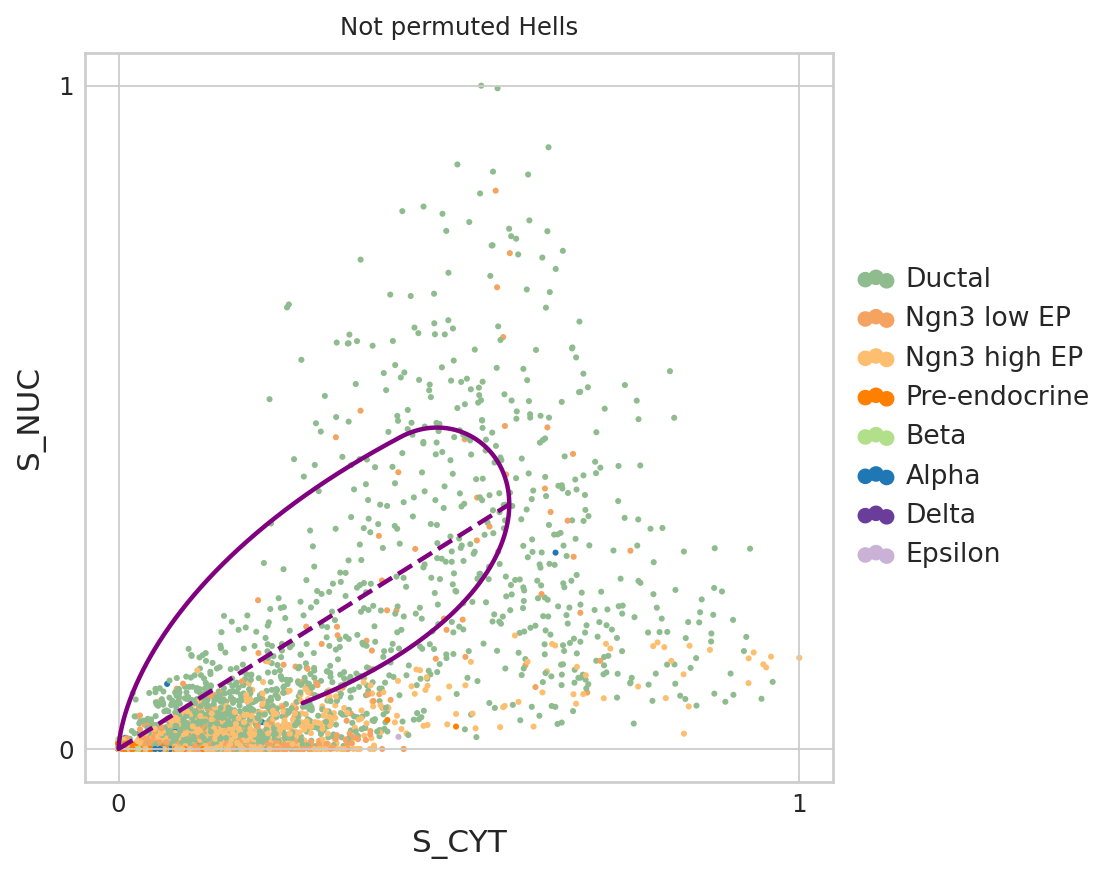

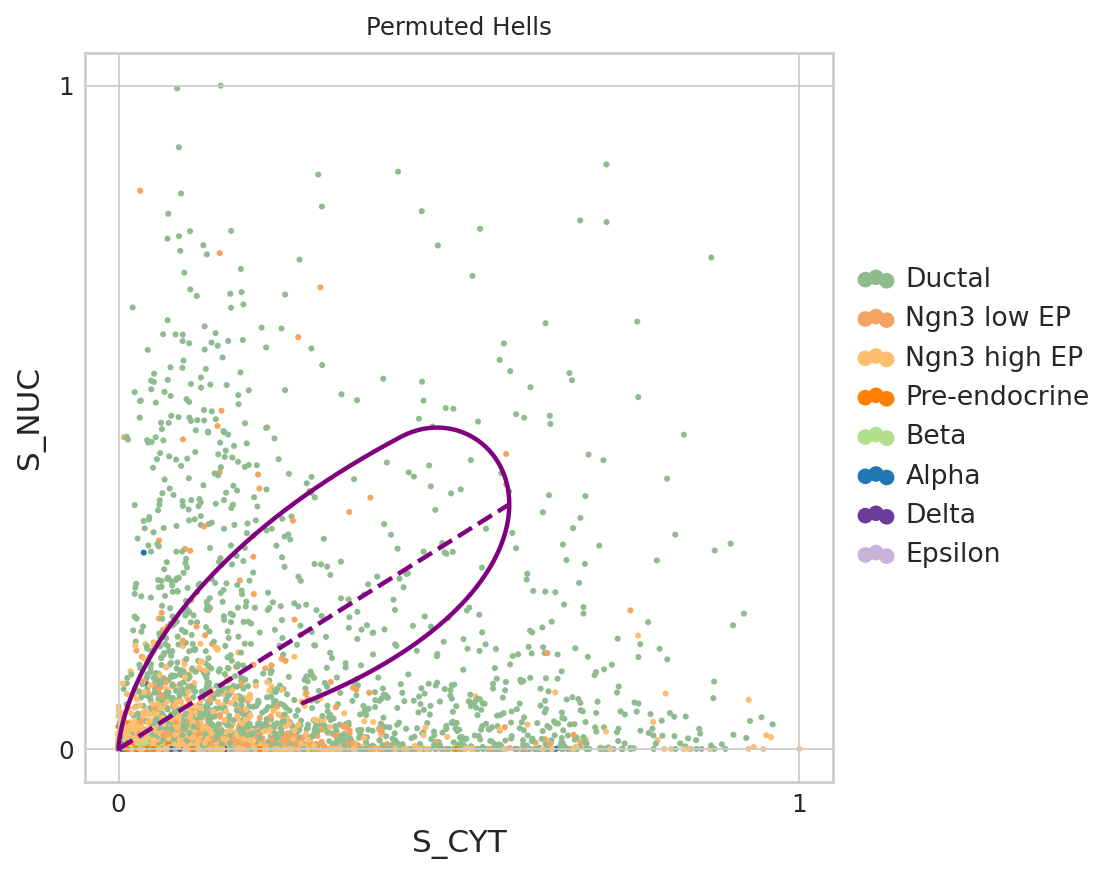

In [30]:
for gene in plot_genes:
    # s_nuc vs s_cyt
    with mplscience.style_context():
        sns.set_style(style="whitegrid")
        fig, ax = plt.subplots(figsize=(6, 6))
        ax = scv.pl.scatter(
            adata,
            x=adata[:, gene].layers["Ms_cyt"],
            y=adata[:, gene].layers["Ms_nuc"],
            color="celltype",
            show=False,
            frameon=True,
            legend_loc="right margin",
            title=f"Not permuted {gene}",
            ax=ax,
            size=30,
        )

        scv.pl.plot_nuc_cyt_dynamics(adata, gene, "purple", ax, "Ms_cyt", "Ms_nuc")
        ax.set_xlabel("S_CYT")
        ax.set_ylabel("S_NUC")

        plt.show()
        if SAVE_FIGURES:
            path = FIG_DIR / "permutation_scores"
            if not os.path.exists(path):
                path.mkdir()
            fig.savefig(path / f"{gene}_snuc_scyt_e15.svg", format="svg", transparent=True, bbox_inches="tight")

    with mplscience.style_context():
        sns.set_style(style="whitegrid")
        fig, ax = plt.subplots(figsize=(6, 6))
        ax = scv.pl.scatter(
            adata,
            x=permuted_adata[:, gene].layers["Ms_cyt"],
            y=permuted_adata[:, gene].layers["Ms_nuc"],
            color="celltype",
            show=False,
            frameon=True,
            legend_loc="right margin",
            title=f"Permuted {gene}",
            ax=ax,
            size=30,
        )

        scv.pl.plot_nuc_cyt_dynamics(adata, gene, "purple", ax, "Ms_cyt", "Ms_nuc")
        ax.set_xlabel("S_CYT")
        ax.set_ylabel("S_NUC")

        plt.show()
        if SAVE_FIGURES:
            path = FIG_DIR / "permutation_scores"
            if not os.path.exists(path):
                path.mkdir()
            fig.savefig(
                path / f"permuted_{gene}_snuc_scyt_e15.svg", format="svg", transparent=True, bbox_inches="tight"
            )

### 2. Spliced Cytoplasm vs. Unspliced Nucleus

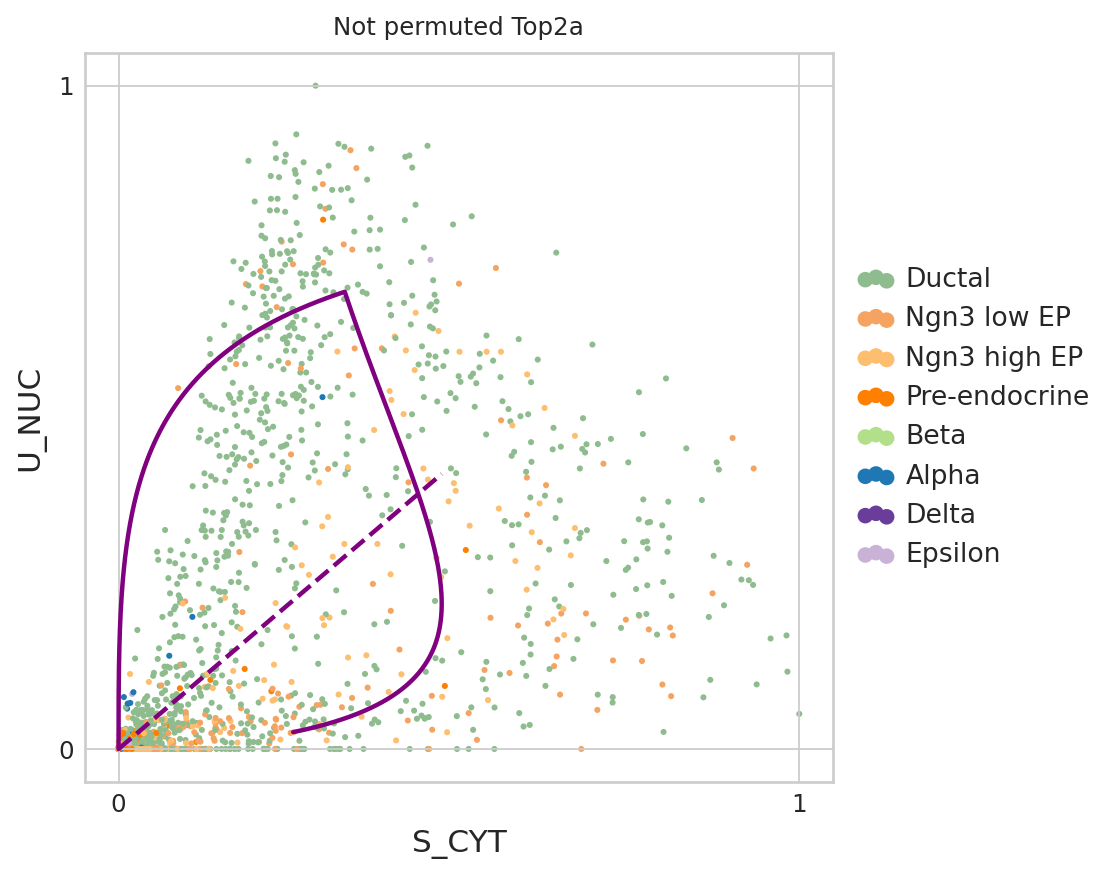

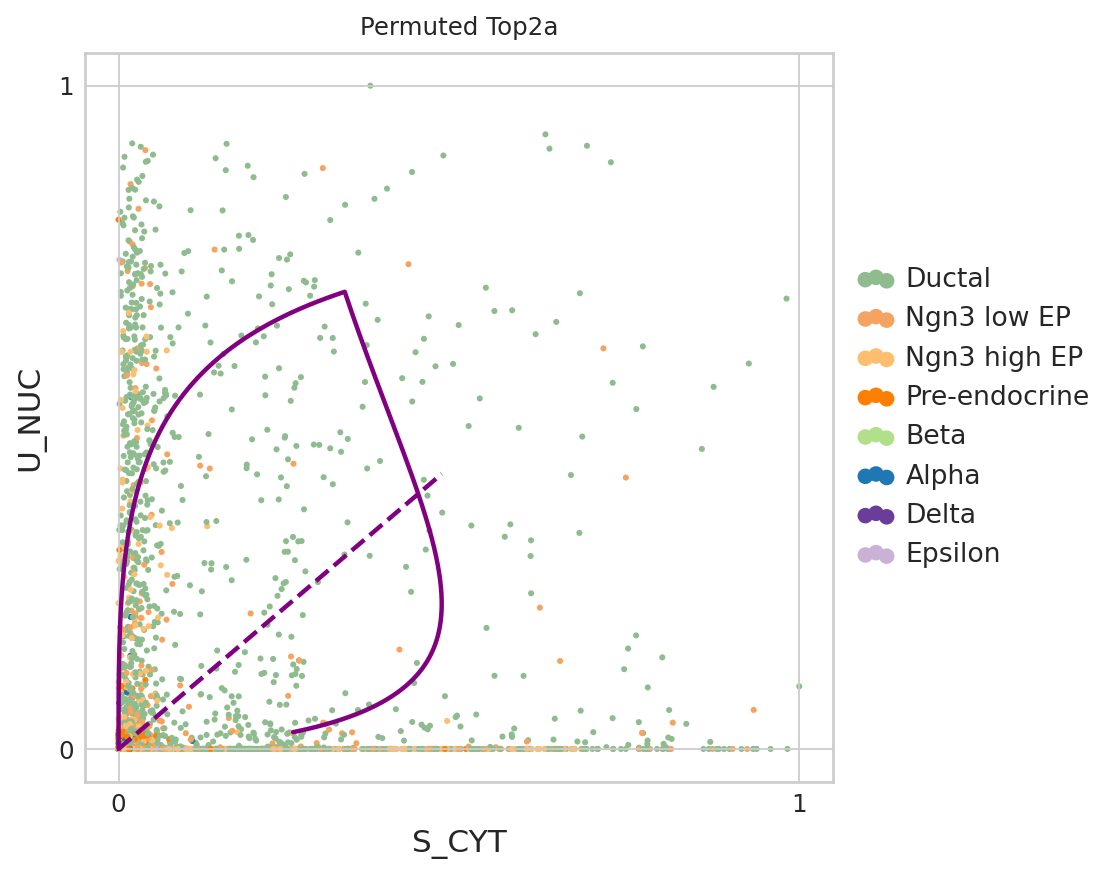

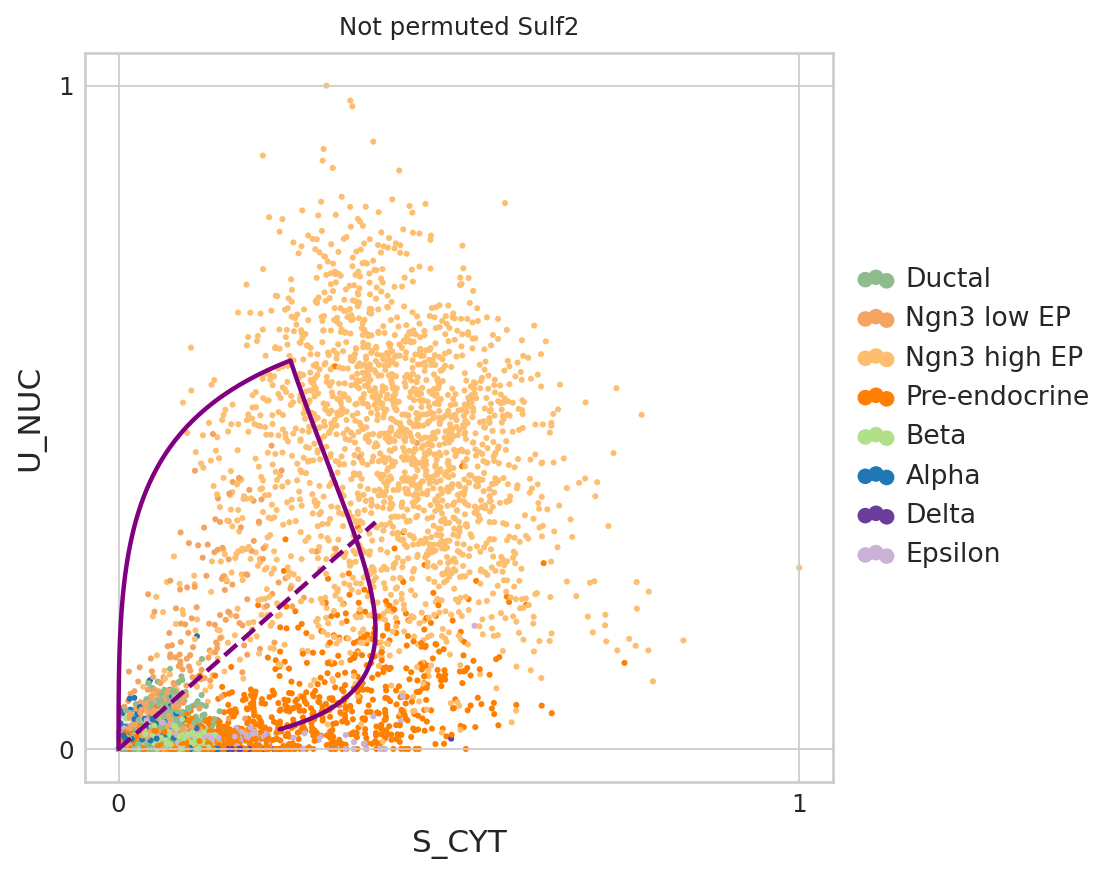

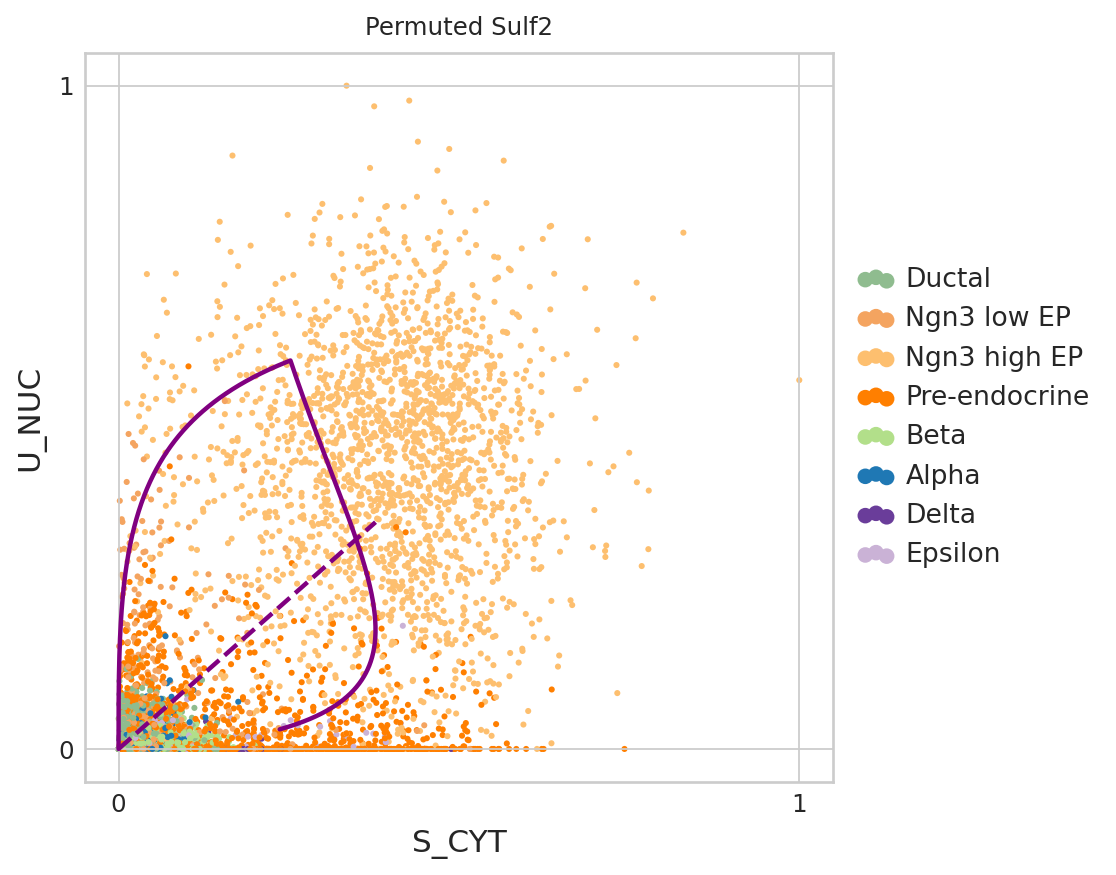

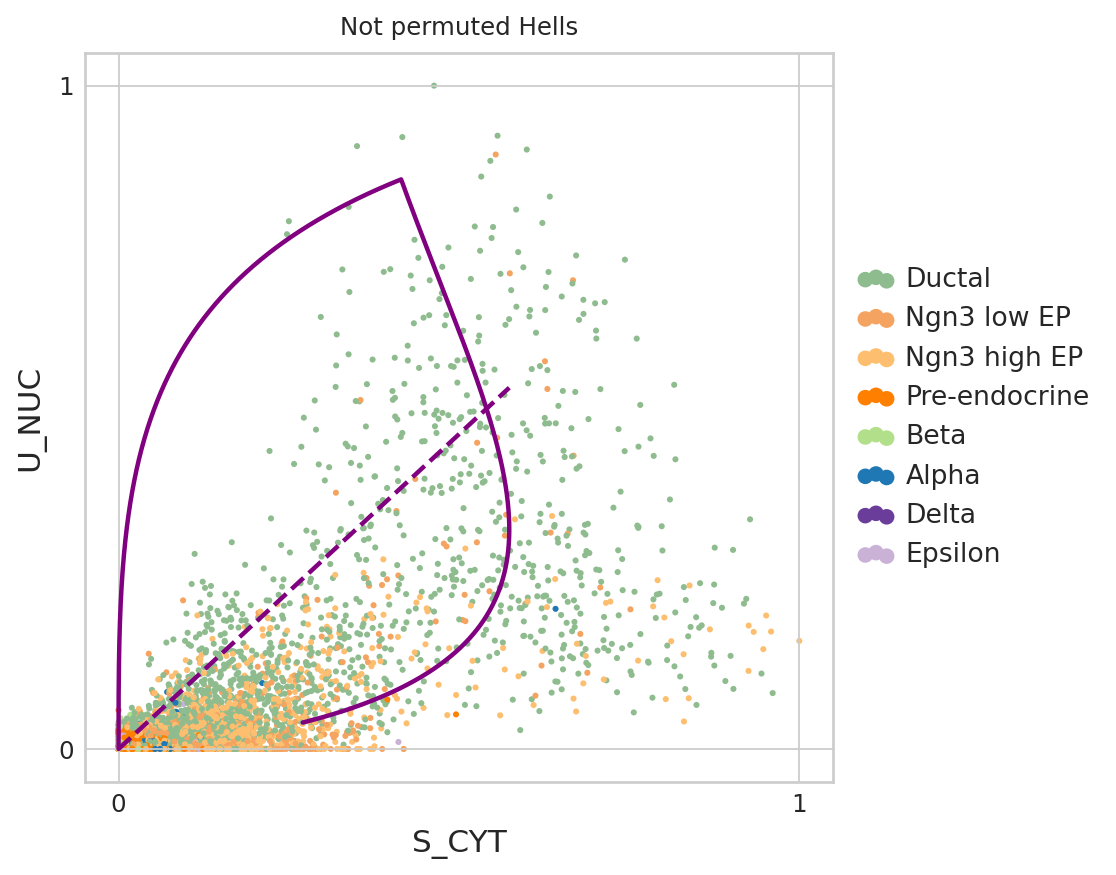

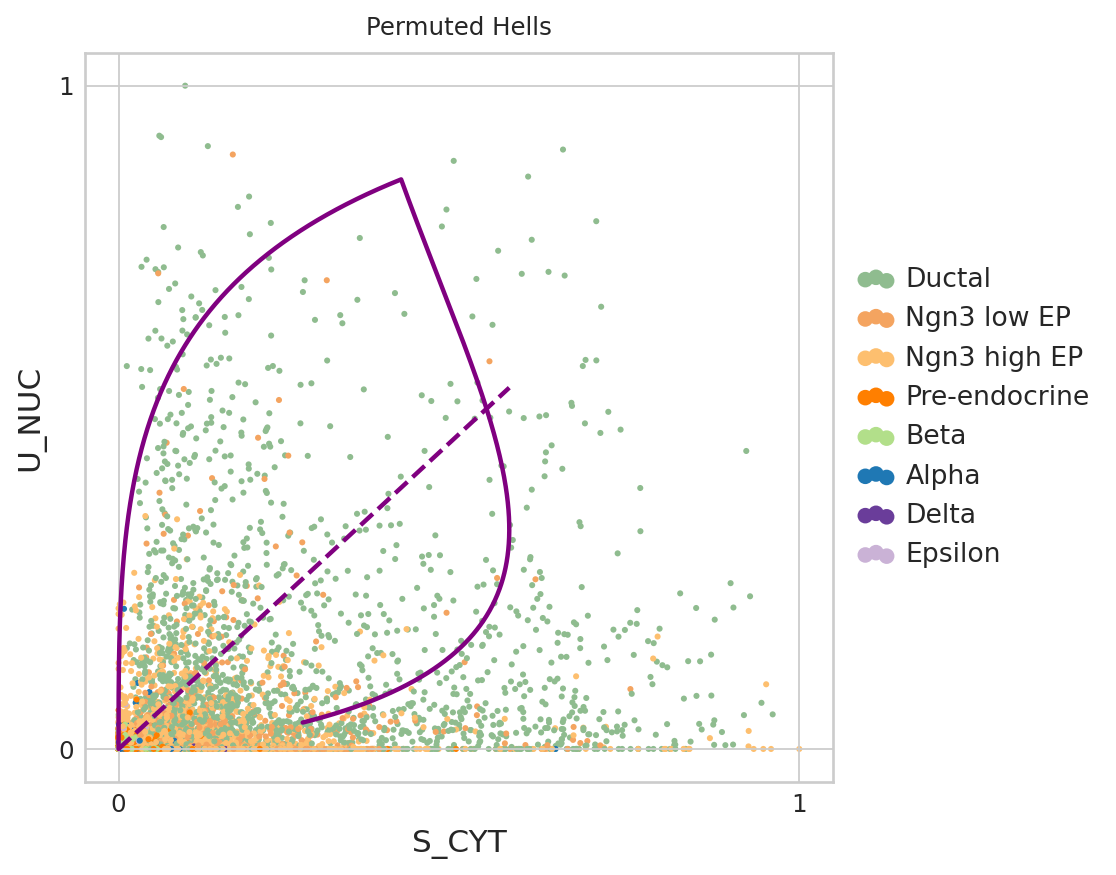

In [31]:
for gene in plot_genes:
    # s_nuc vs s_cyt
    with mplscience.style_context():
        sns.set_style(style="whitegrid")
        fig, ax = plt.subplots(figsize=(6, 6))
        ax = scv.pl.scatter(
            adata,
            x=adata[:, gene].layers["Ms_cyt"],
            y=adata[:, gene].layers["Mu_nuc"],
            color="celltype",
            show=False,
            frameon=True,
            legend_loc="right margin",
            title=f"Not permuted {gene}",
            ax=ax,
            size=30,
        )

        scv.pl.plot_nuc_cyt_dynamics(adata, gene, "purple", ax, "Ms_cyt", "Mu_nuc")
        ax.set_xlabel("S_CYT")
        ax.set_ylabel("U_NUC")

        plt.show()
        if SAVE_FIGURES:
            path = FIG_DIR / "permutation_scores"
            if not os.path.exists(path):
                path.mkdir()
            fig.savefig(path / f"{gene}_unuc_scyt_e15.svg", format="svg", transparent=True, bbox_inches="tight")

    with mplscience.style_context():
        sns.set_style(style="whitegrid")
        fig, ax = plt.subplots(figsize=(6, 6))
        ax = scv.pl.scatter(
            adata,
            x=permuted_adata[:, gene].layers["Ms_cyt"],
            y=permuted_adata[:, gene].layers["Mu_nuc"],
            color="celltype",
            show=False,
            frameon=True,
            legend_loc="right margin",
            title=f"Permuted {gene}",
            ax=ax,
            size=30,
        )

        scv.pl.plot_nuc_cyt_dynamics(adata, gene, "purple", ax, "Ms_cyt", "Mu_nuc")
        ax.set_xlabel("S_CYT")
        ax.set_ylabel("U_NUC")

        plt.show()
        if SAVE_FIGURES:
            path = FIG_DIR / "permutation_scores"
            if not os.path.exists(path):
                path.mkdir()
            fig.savefig(
                path / f"permuted_{gene}_unuc_scyt_e15.svg", format="svg", transparent=True, bbox_inches="tight"
            )

### 3. Spliced Nucleus vs. Unspliced Nucleus

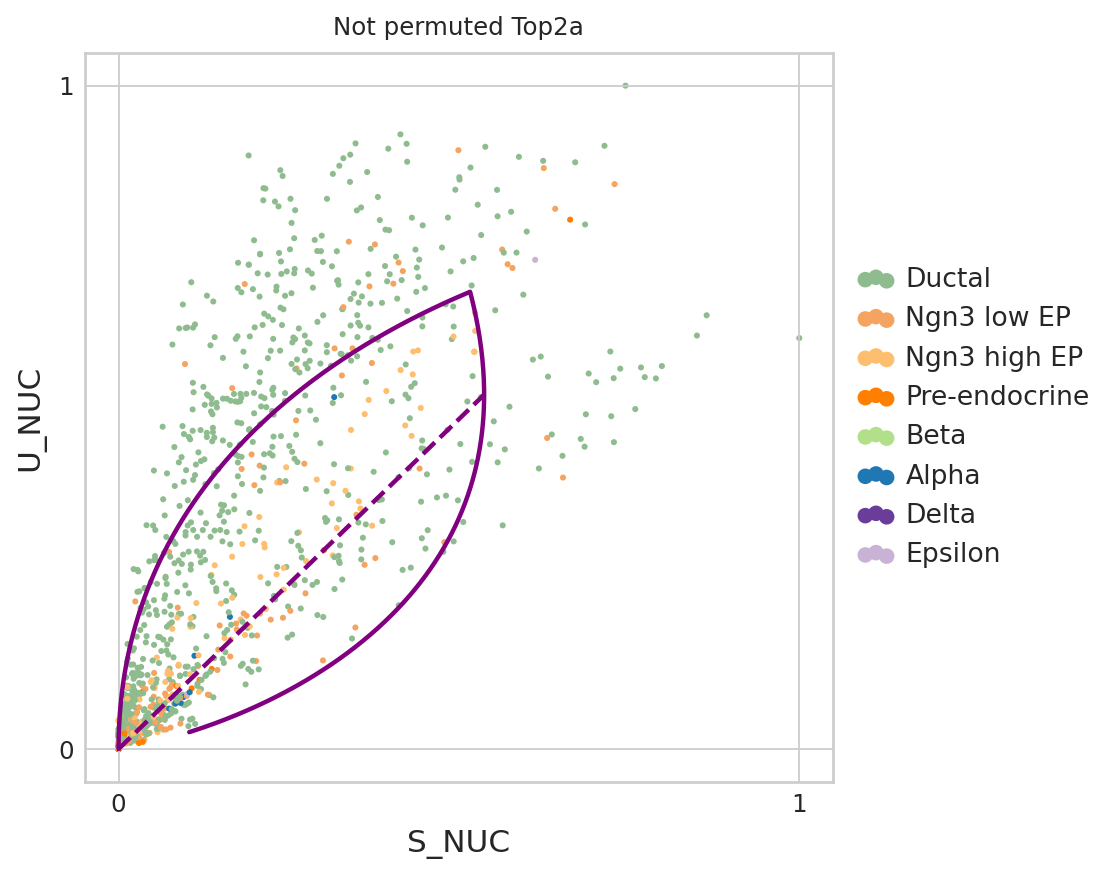

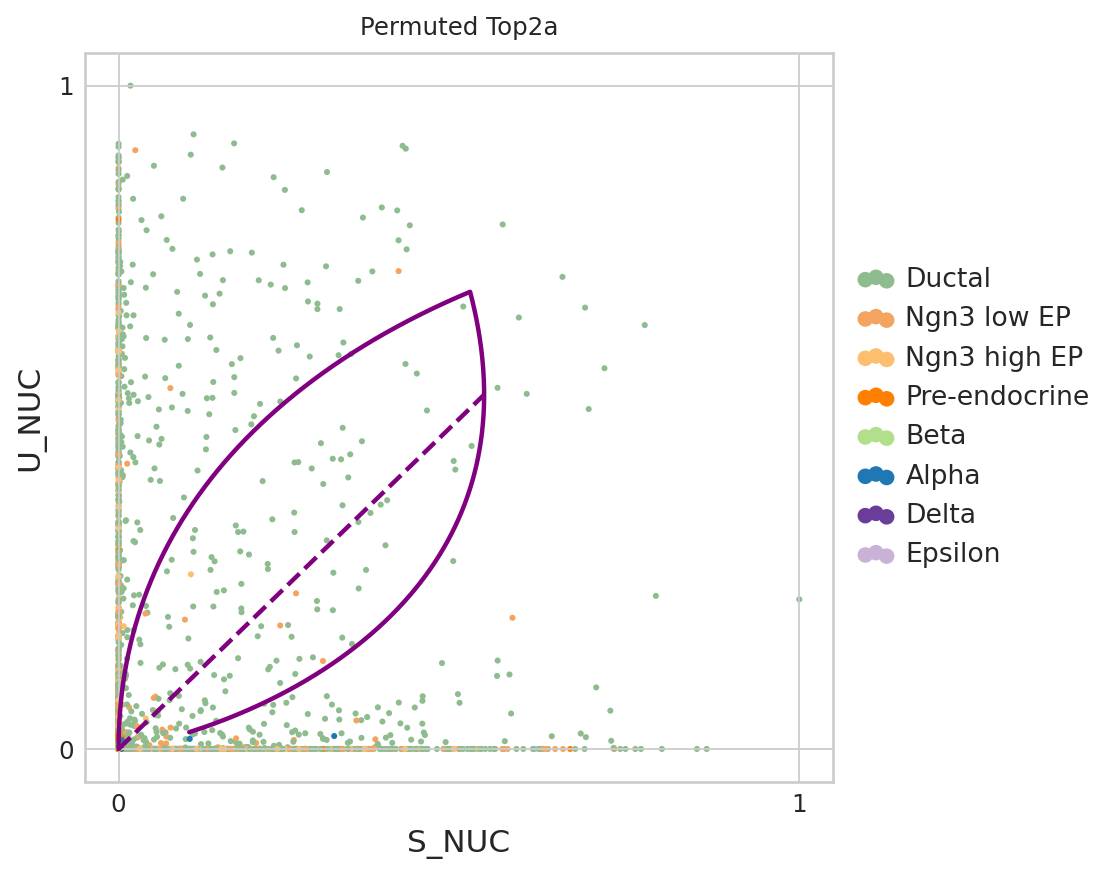

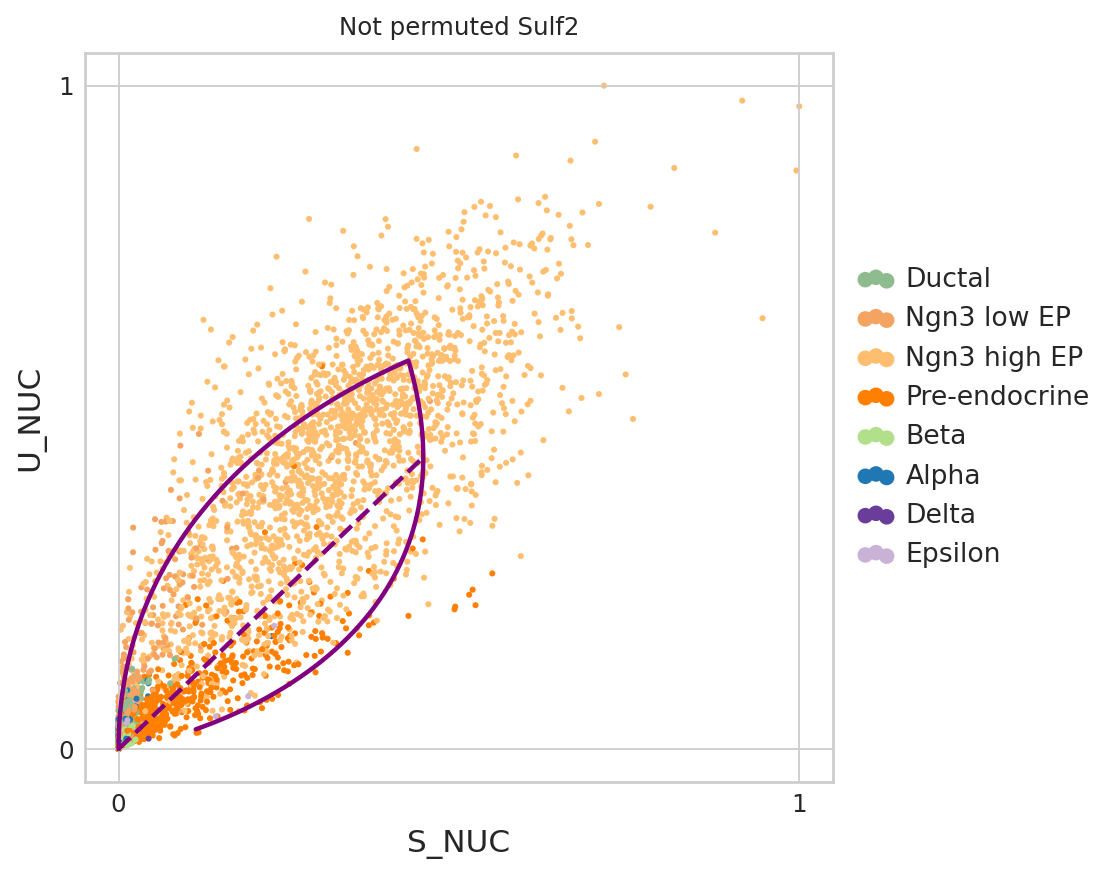

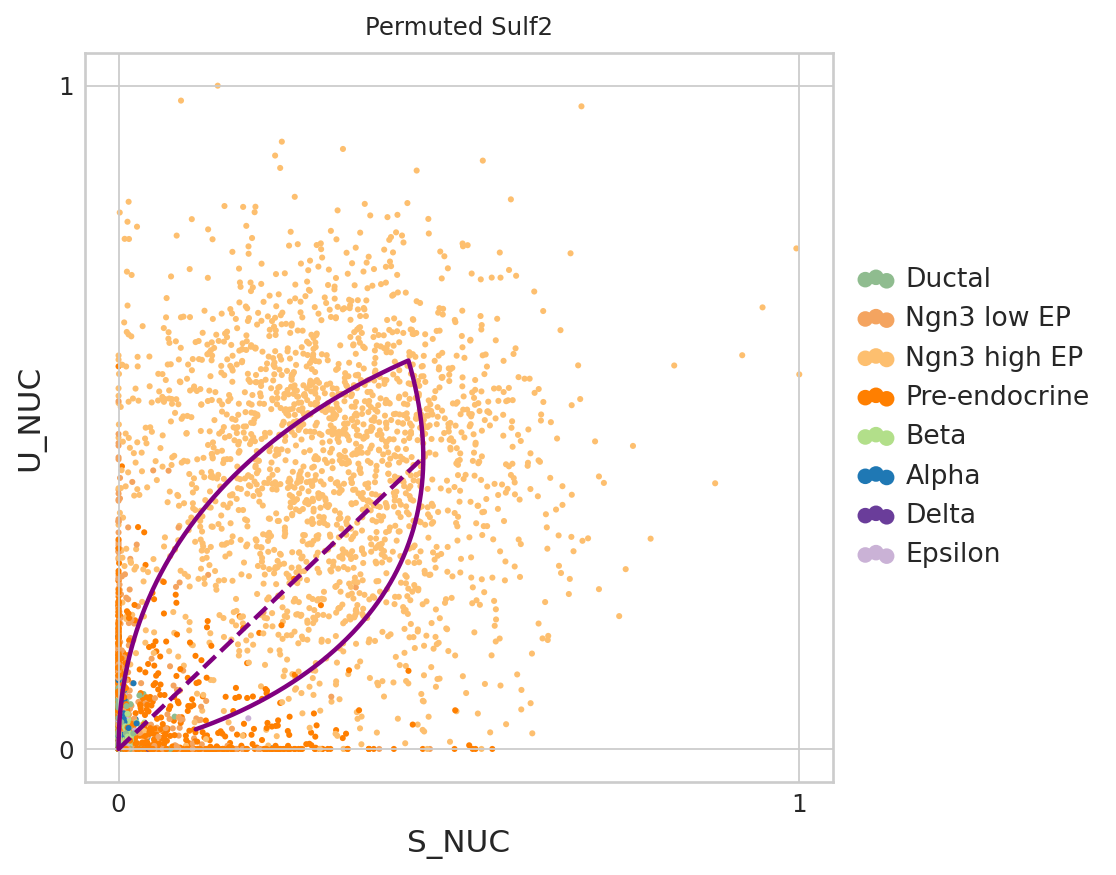

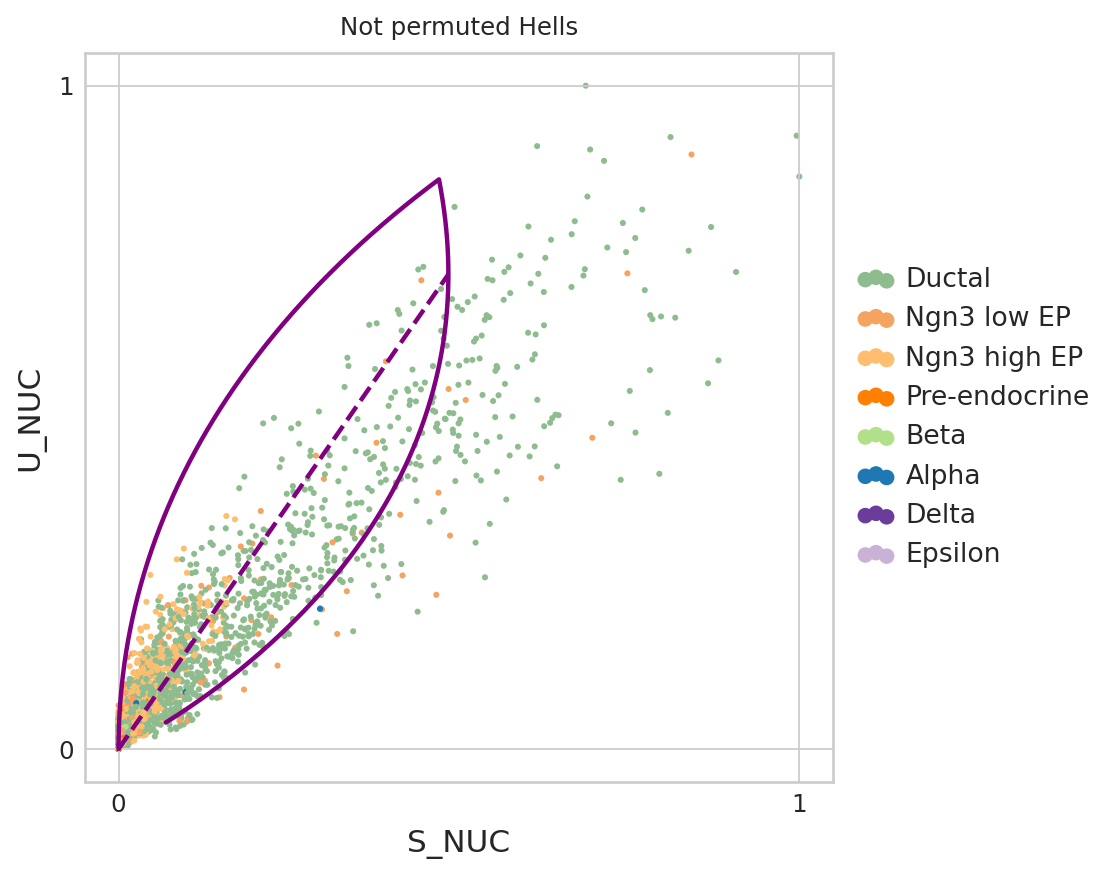

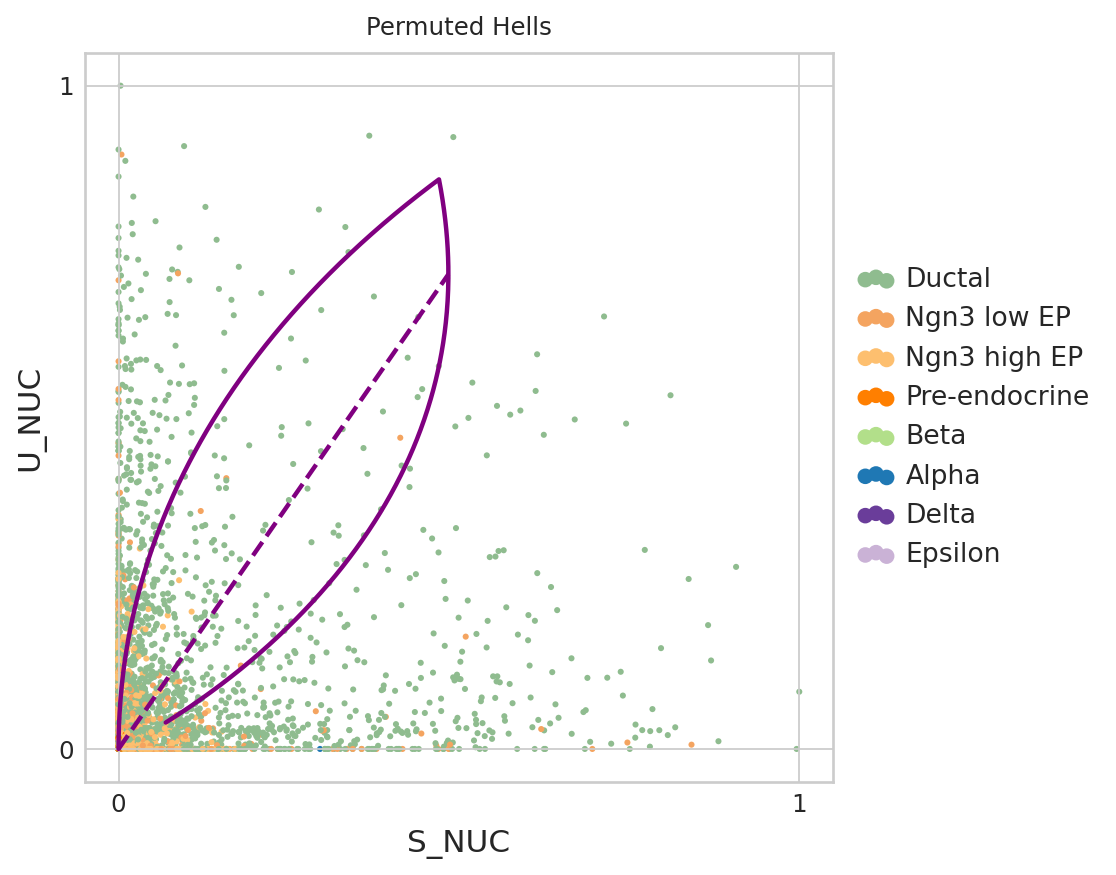

In [32]:
for gene in plot_genes:
    # s_nuc vs s_cyt
    with mplscience.style_context():
        sns.set_style(style="whitegrid")
        fig, ax = plt.subplots(figsize=(6, 6))
        ax = scv.pl.scatter(
            adata,
            x=adata[:, gene].layers["Ms_nuc"],
            y=adata[:, gene].layers["Mu_nuc"],
            color="celltype",
            show=False,
            frameon=True,
            legend_loc="right margin",
            title=f"Not permuted {gene}",
            ax=ax,
            size=30,
        )

        scv.pl.plot_nuc_cyt_dynamics(adata, gene, "purple", ax, "Ms_nuc", "Mu_nuc")
        ax.set_xlabel("S_NUC")
        ax.set_ylabel("U_NUC")

        plt.show()
        if SAVE_FIGURES:
            path = FIG_DIR / "permutation_scores"
            if not os.path.exists(path):
                path.mkdir()
            fig.savefig(path / f"{gene}_unuc_snuc_e15.svg", format="svg", transparent=True, bbox_inches="tight")

    with mplscience.style_context():
        sns.set_style(style="whitegrid")
        fig, ax = plt.subplots(figsize=(6, 6))
        ax = scv.pl.scatter(
            adata,
            x=permuted_adata[:, gene].layers["Ms_nuc"],
            y=permuted_adata[:, gene].layers["Mu_nuc"],
            color="celltype",
            show=False,
            frameon=True,
            legend_loc="right margin",
            title=f"Permuted {gene}",
            ax=ax,
            size=30,
        )

        scv.pl.plot_nuc_cyt_dynamics(adata, gene, "purple", ax, "Ms_nuc", "Mu_nuc")
        ax.set_xlabel("S_NUC")
        ax.set_ylabel("U_NUC")

        plt.show()
        if SAVE_FIGURES:
            path = FIG_DIR / "permutation_scores"
            if not os.path.exists(path):
                path.mkdir()
            fig.savefig(
                path / f"permuted_{gene}_unuc_snuc_e15.svg", format="svg", transparent=True, bbox_inches="tight"
            )

## Single-cell phase portraits

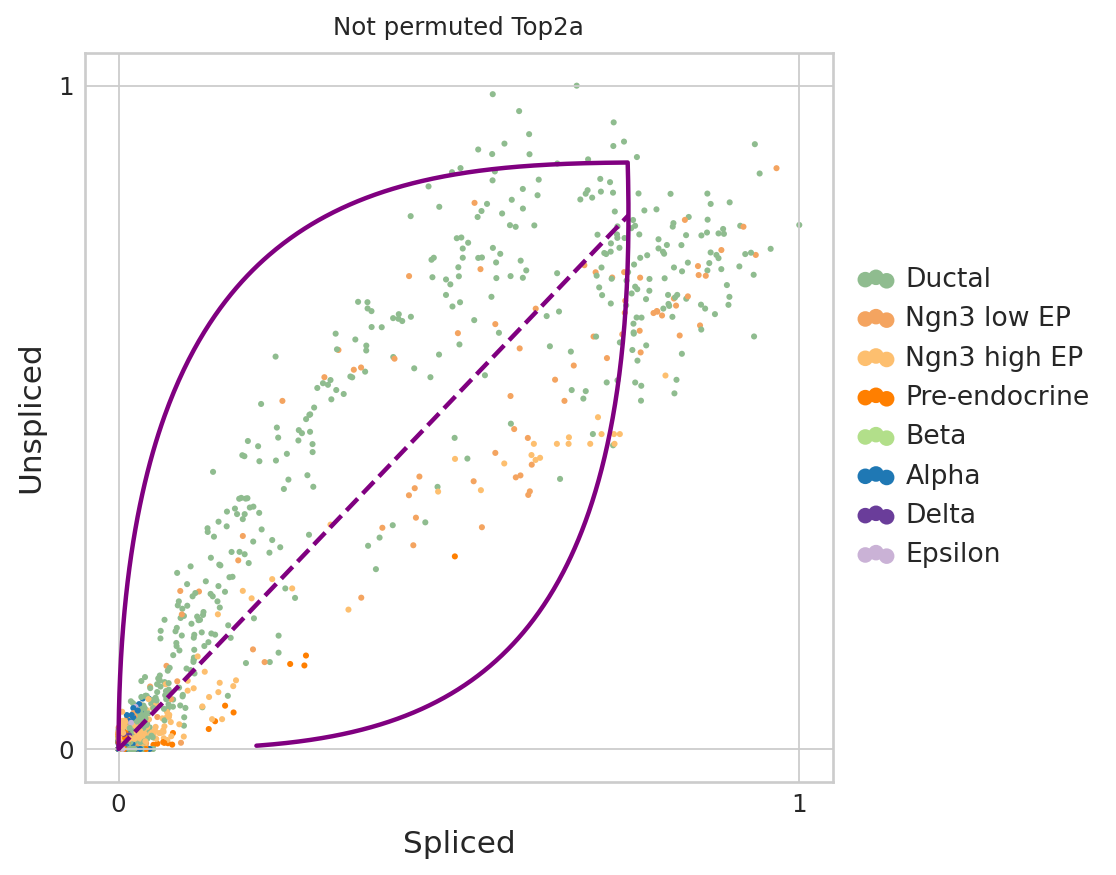

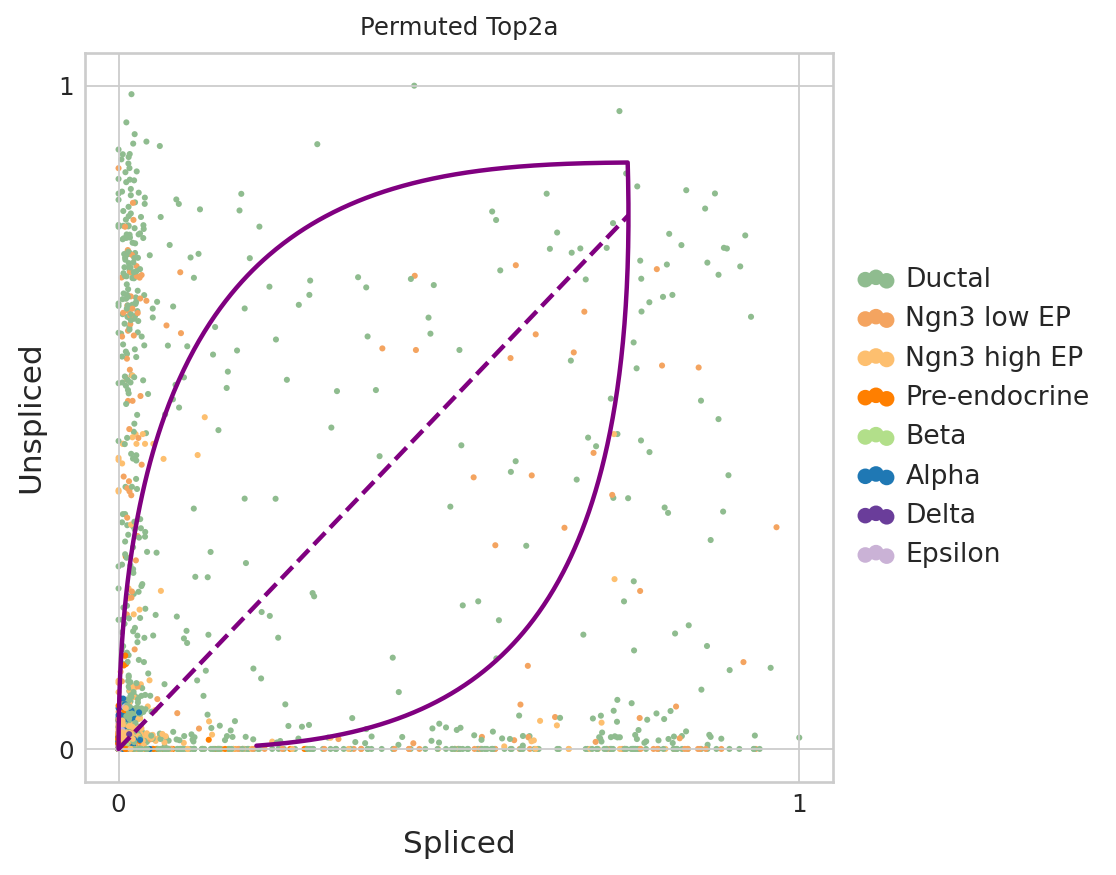

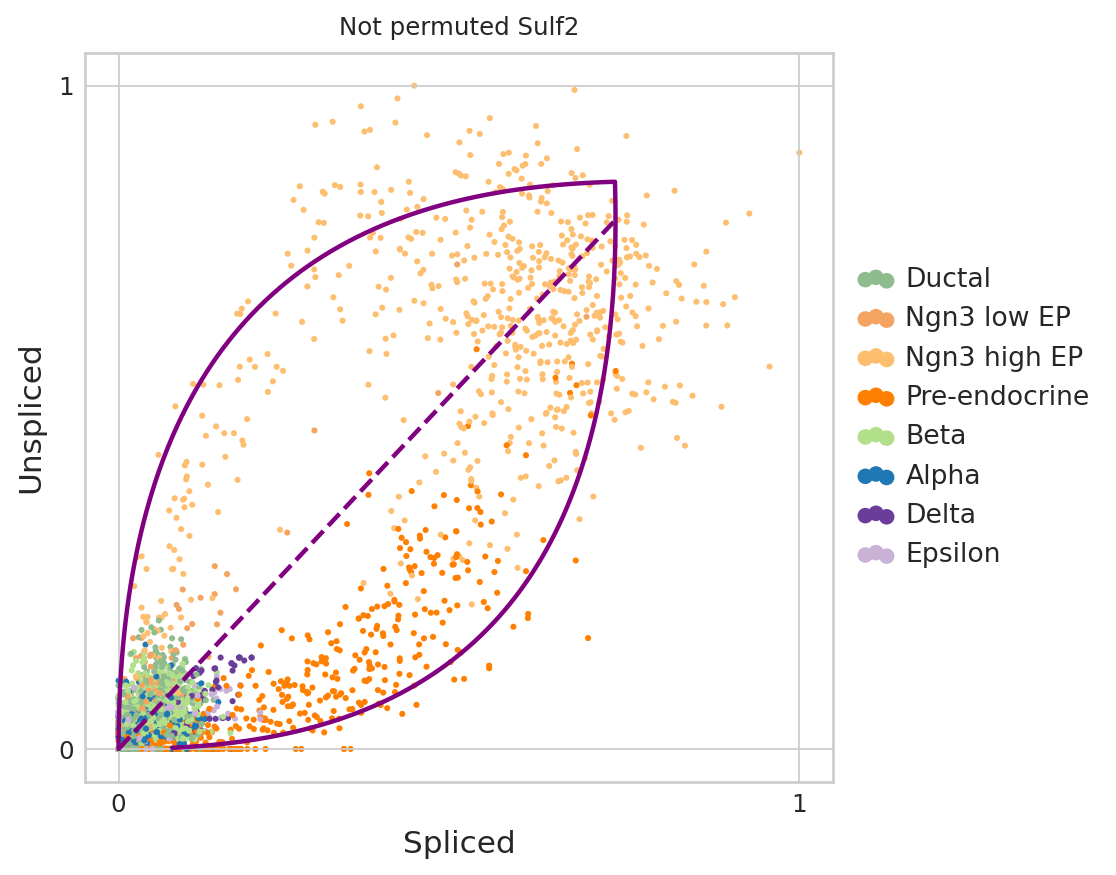

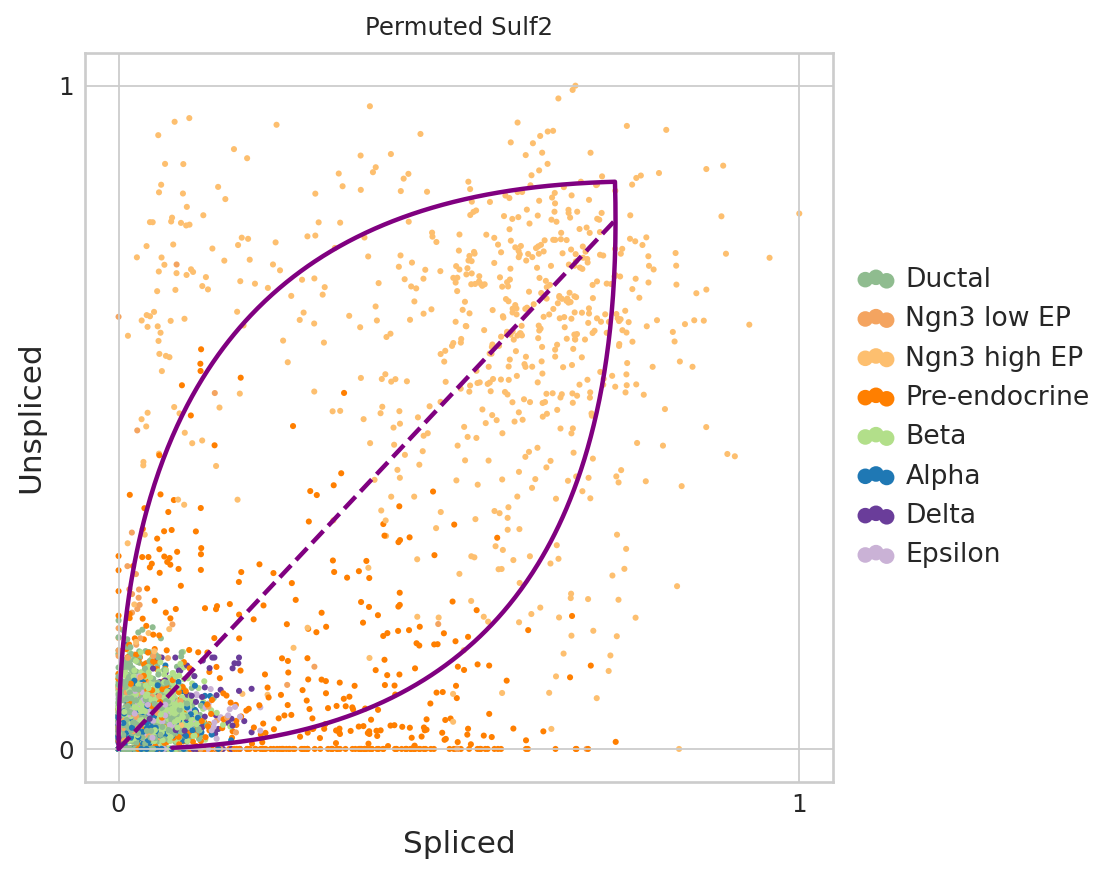

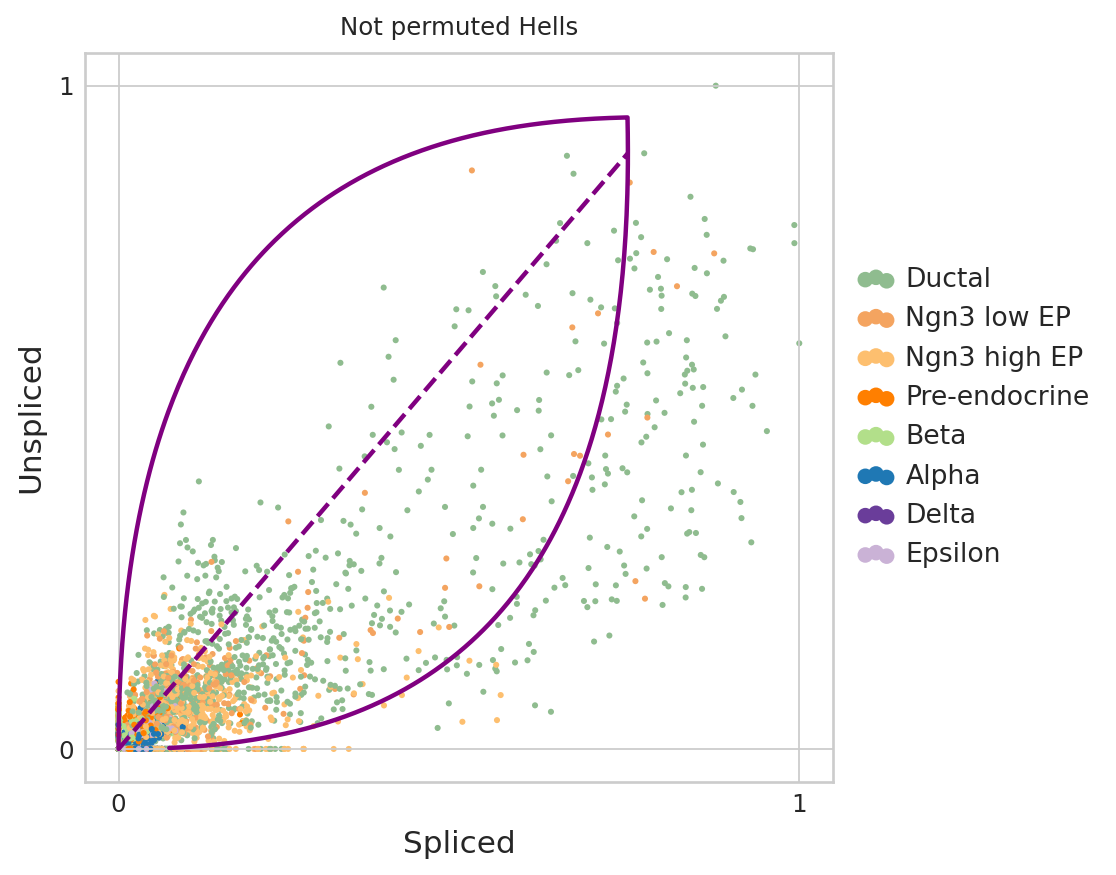

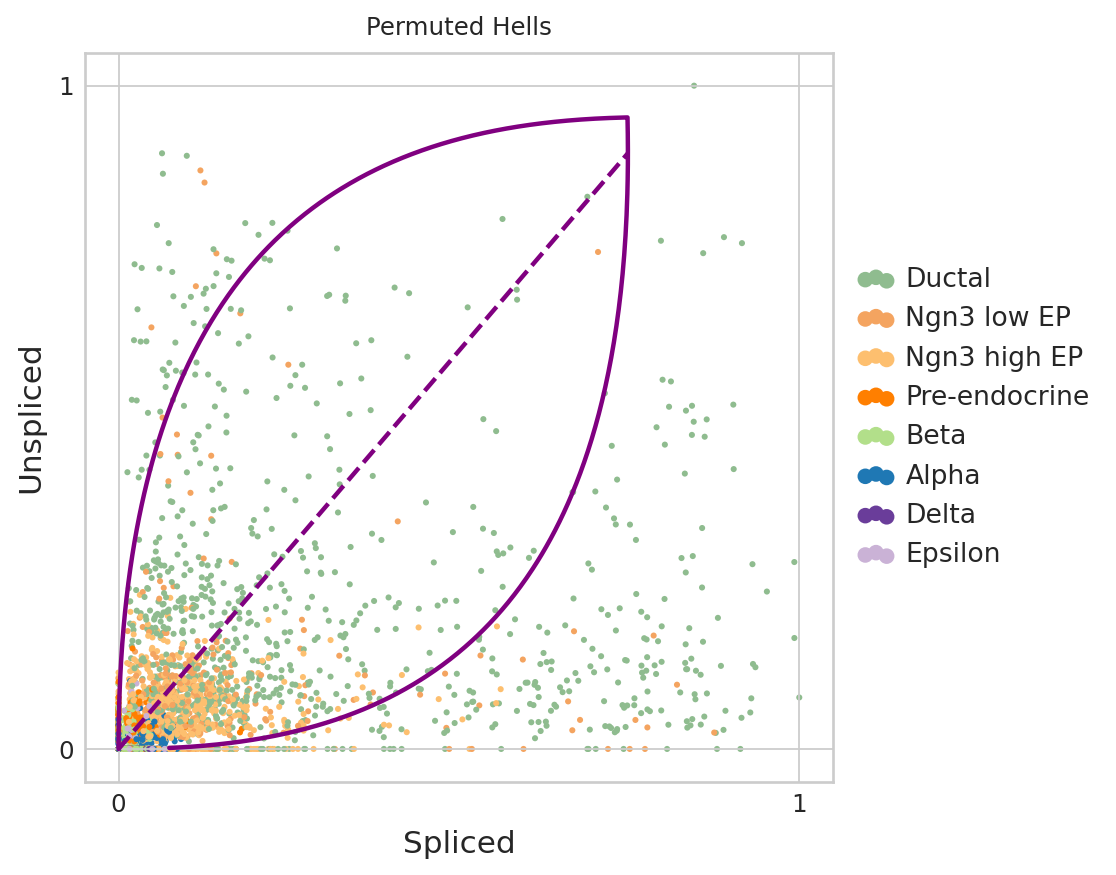

In [33]:
for gene in plot_genes:
    # s_nuc vs s_cyt
    with mplscience.style_context():
        sns.set_style(style="whitegrid")
        fig, ax = plt.subplots(figsize=(6, 6))
        ax = scv.pl.scatter(
            adata_sc,
            x=adata_sc[:, gene].layers["Ms"],
            y=adata_sc[:, gene].layers["Mu"],
            color="celltype",
            show=False,
            frameon=True,
            legend_loc="right margin",
            title=f"Not permuted {gene}",
            ax=ax,
            size=30,
        )
        plot_dynamics_(adata_sc, gene, "purple", ax)
        ax.set_xlabel("Spliced")
        ax.set_ylabel("Unspliced")

        plt.show()
        if SAVE_FIGURES:
            path = FIG_DIR / "permutation_scores"
            if not os.path.exists(path):
                path.mkdir()
            fig.savefig(path / f"{gene}_u_s_sc_e15.svg", format="svg", transparent=True, bbox_inches="tight")

    with mplscience.style_context():
        sns.set_style(style="whitegrid")
        fig, ax = plt.subplots(figsize=(6, 6))
        ax = scv.pl.scatter(
            adata_sc,
            x=permuted_adata_sc[:, gene].layers["Ms"],
            y=permuted_adata_sc[:, gene].layers["Mu"],
            color="celltype",
            show=False,
            frameon=True,
            legend_loc="right margin",
            title=f"Permuted {gene}",
            ax=ax,
            size=30,
        )
        plot_dynamics_(adata_sc, gene, "purple", ax)
        ax.set_xlabel("Spliced")
        ax.set_ylabel("Unspliced")

        plt.show()
        if SAVE_FIGURES:
            path = FIG_DIR / "permutation_scores"
            if not os.path.exists(path):
                path.mkdir()
            fig.savefig(path / f"permuted_{gene}_u_s_sc_e15.svg", format="svg", transparent=True, bbox_inches="tight")

### 5. Spliced vs. Unspliced on snRNA-data

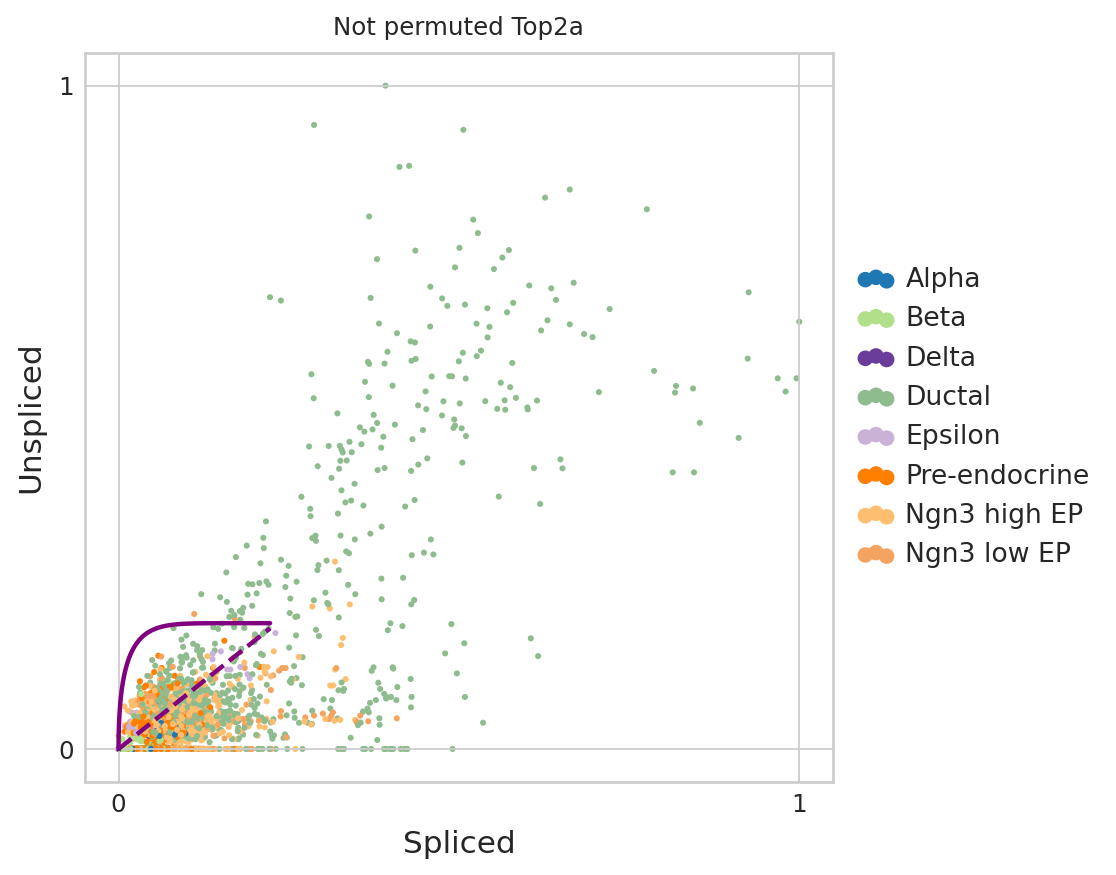

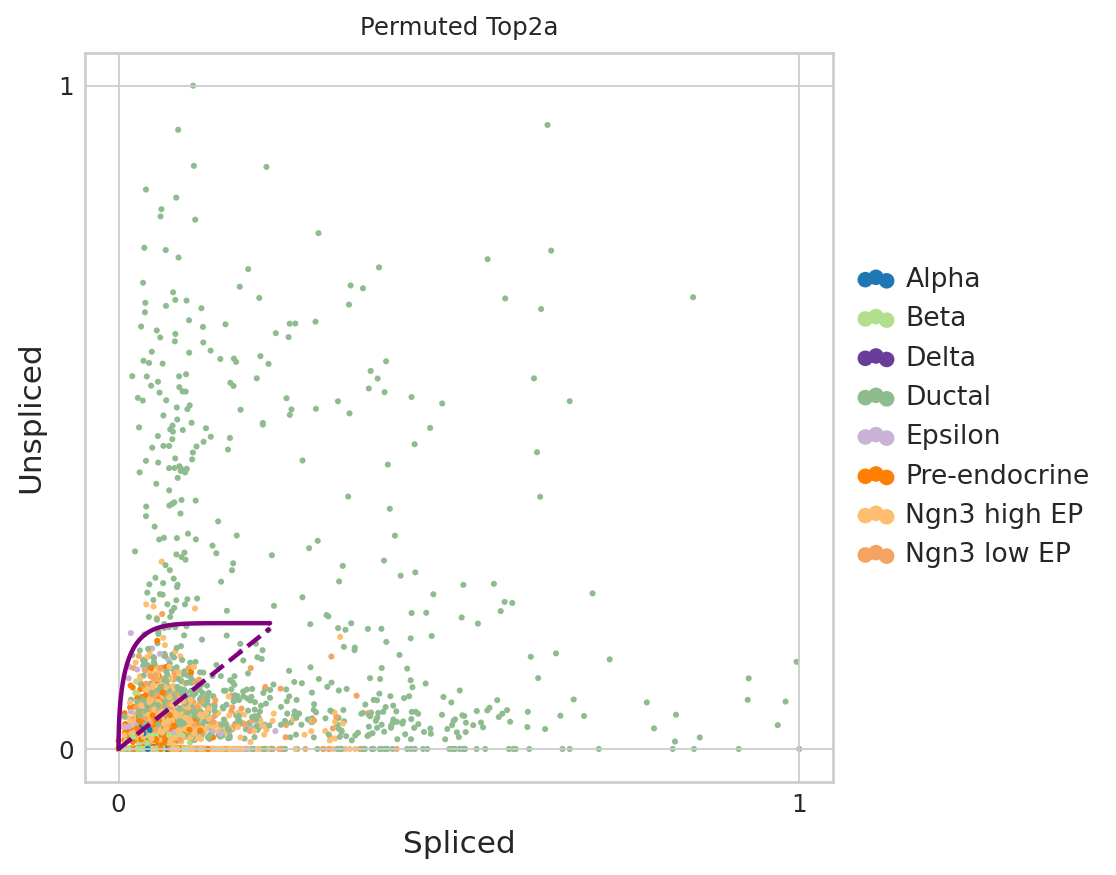

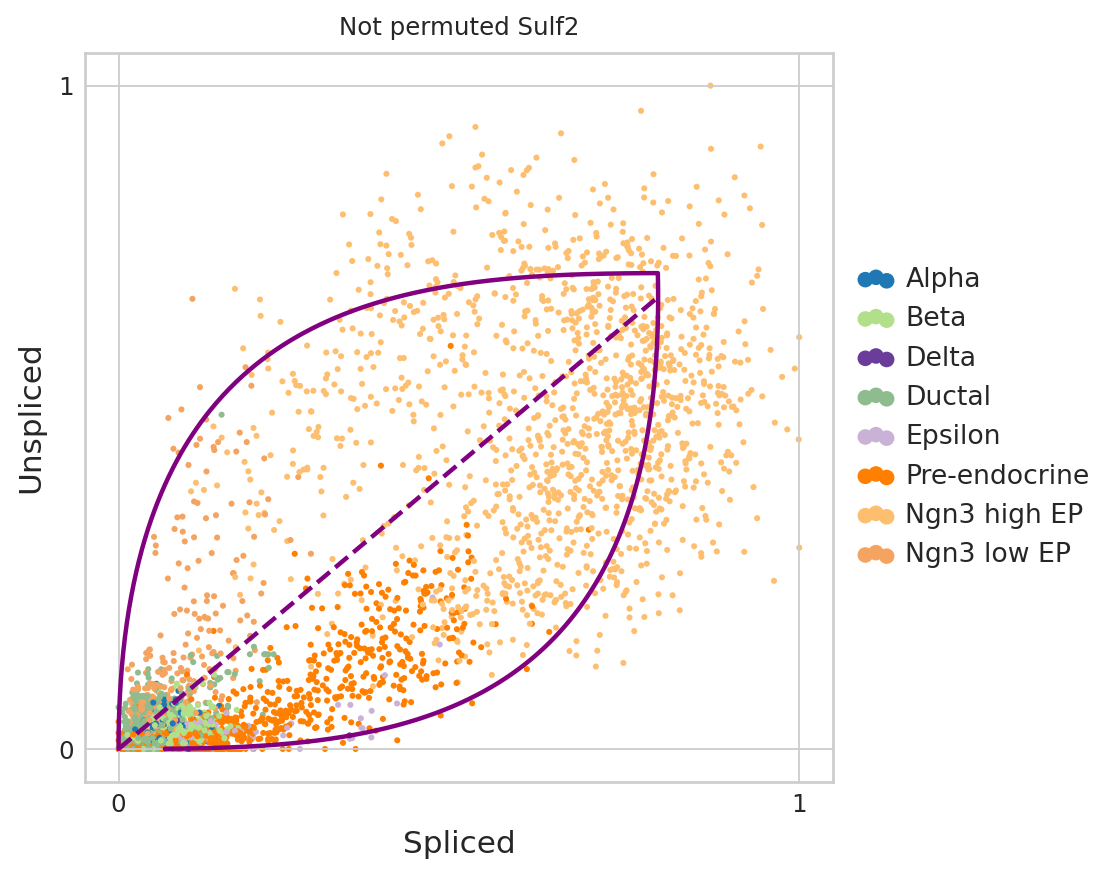

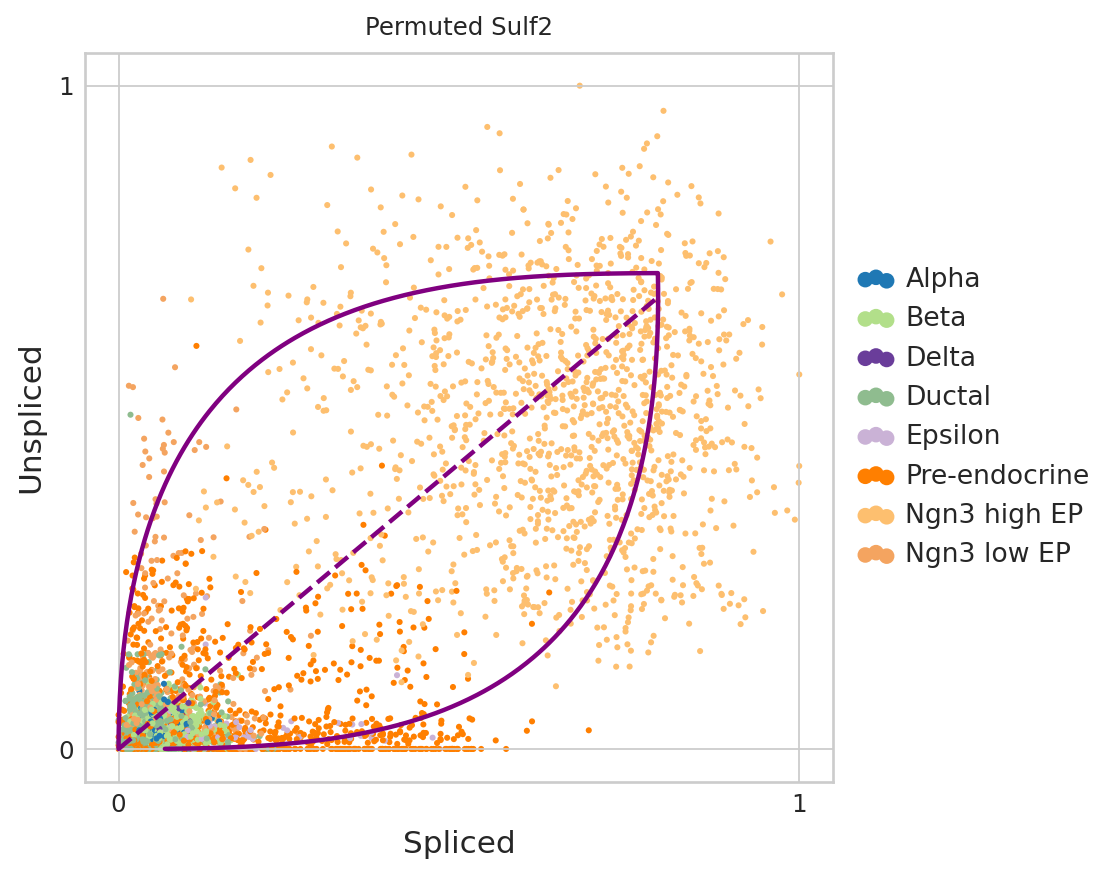

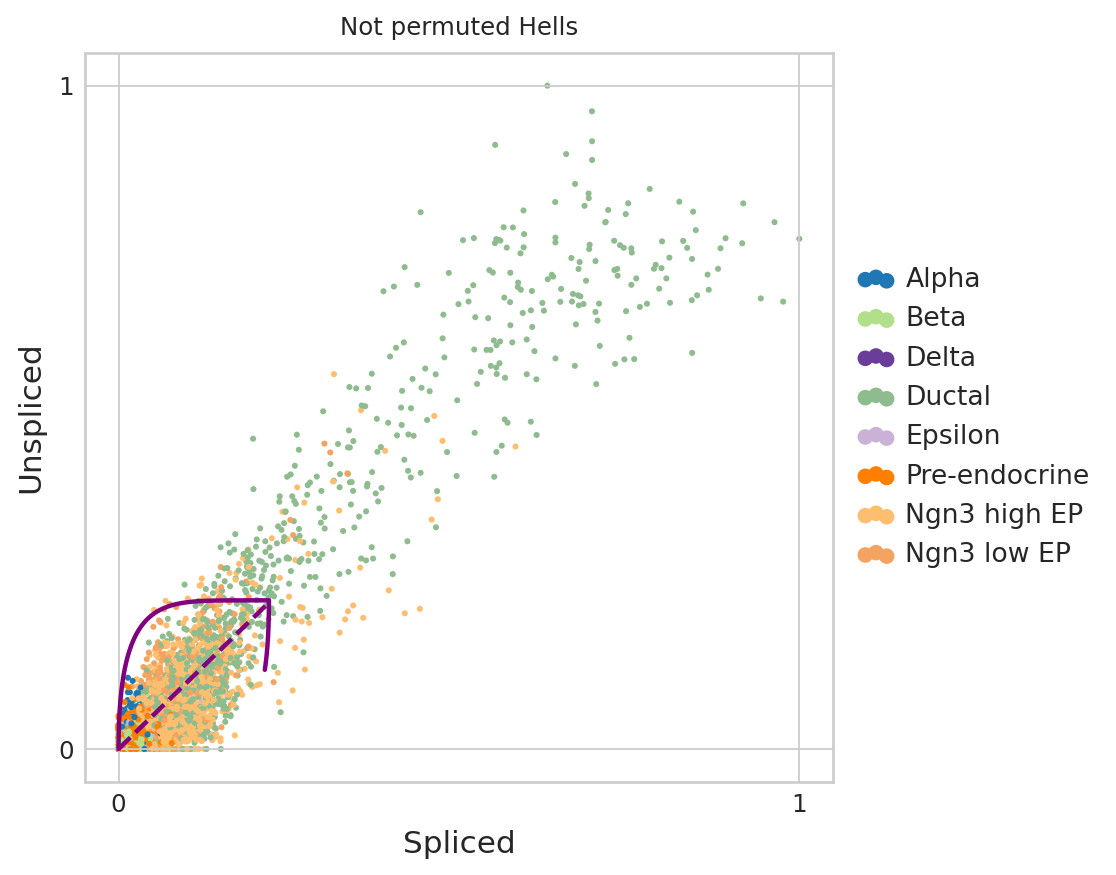

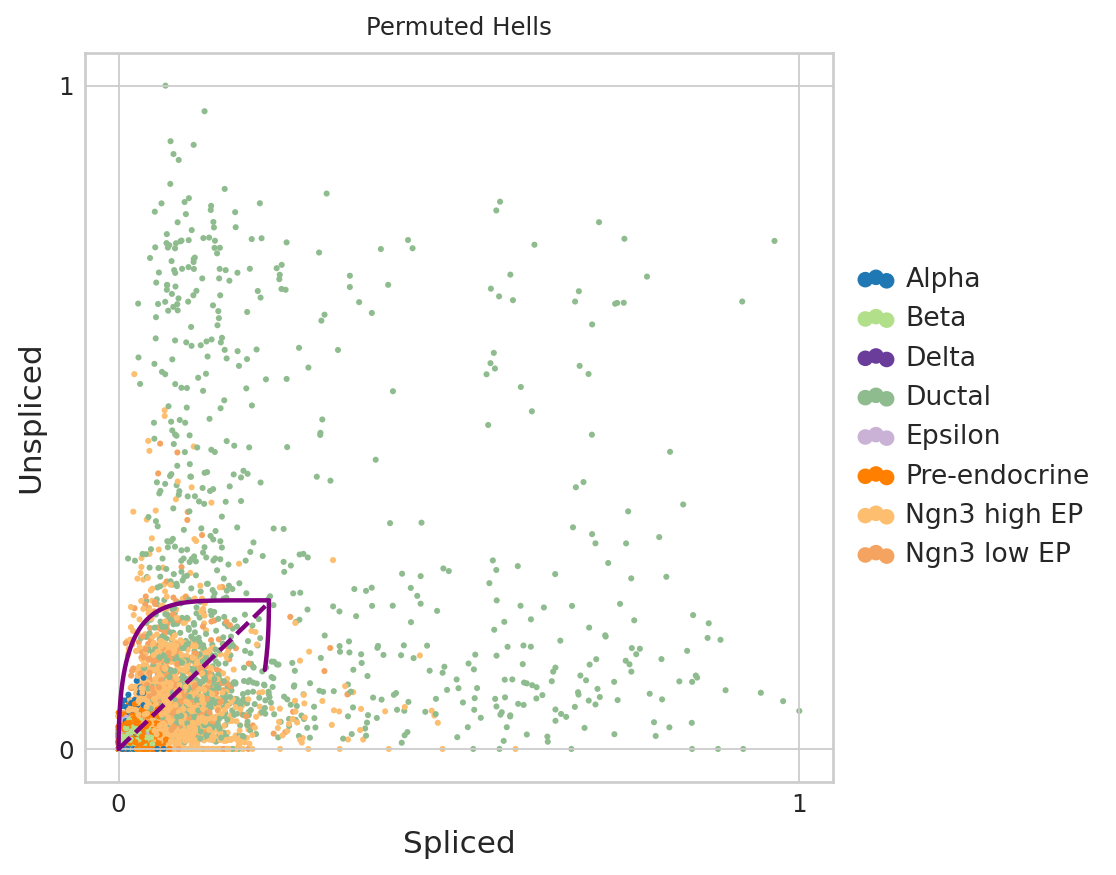

In [34]:
for gene in plot_genes:
    # s_nuc vs s_cyt
    with mplscience.style_context():
        sns.set_style(style="whitegrid")
        fig, ax = plt.subplots(figsize=(6, 6))
        ax = scv.pl.scatter(
            adata_sn,
            x=adata_sn[:, gene].layers["Ms"],
            y=adata_sn[:, gene].layers["Mu"],
            color="celltype",
            show=False,
            frameon=True,
            legend_loc="right margin",
            title=f"Not permuted {gene}",
            ax=ax,
            size=30,
        )
        plot_dynamics_(adata_sn, gene, "purple", ax)
        ax.set_xlabel("Spliced")
        ax.set_ylabel("Unspliced")

        plt.show()
        if SAVE_FIGURES:
            path = FIG_DIR / "permutation_scores"
            if not os.path.exists(path):
                path.mkdir()
            fig.savefig(path / f"{gene}_u_s_sn_e15.svg", format="svg", transparent=True, bbox_inches="tight")

    with mplscience.style_context():
        sns.set_style(style="whitegrid")
        fig, ax = plt.subplots(figsize=(6, 6))
        ax = scv.pl.scatter(
            permuted_adata_sn,
            x=permuted_adata_sn[:, gene].layers["Ms"],
            y=permuted_adata_sn[:, gene].layers["Mu"],
            color="celltype",
            show=False,
            frameon=True,
            legend_loc="right margin",
            title=f"Permuted {gene}",
            ax=ax,
            size=30,
        )
        plot_dynamics_(adata_sn, gene, "purple", ax)
        ax.set_xlabel("Spliced")
        ax.set_ylabel("Unspliced")

        plt.show()
        if SAVE_FIGURES:
            path = FIG_DIR / "permutation_scores"
            if not os.path.exists(path):
                path.mkdir()
            fig.savefig(path / f"permuted_{gene}_u_s_sn_e15.svg", format="svg", transparent=True, bbox_inches="tight")

## Plot permutation score as barplot

In [35]:
adata.uns["celltype_colors"] = celltype_colors
adata_sc.uns["celltype_colors"] = celltype_colors
adata_sn.uns["celltype_colors"] = celltype_colors

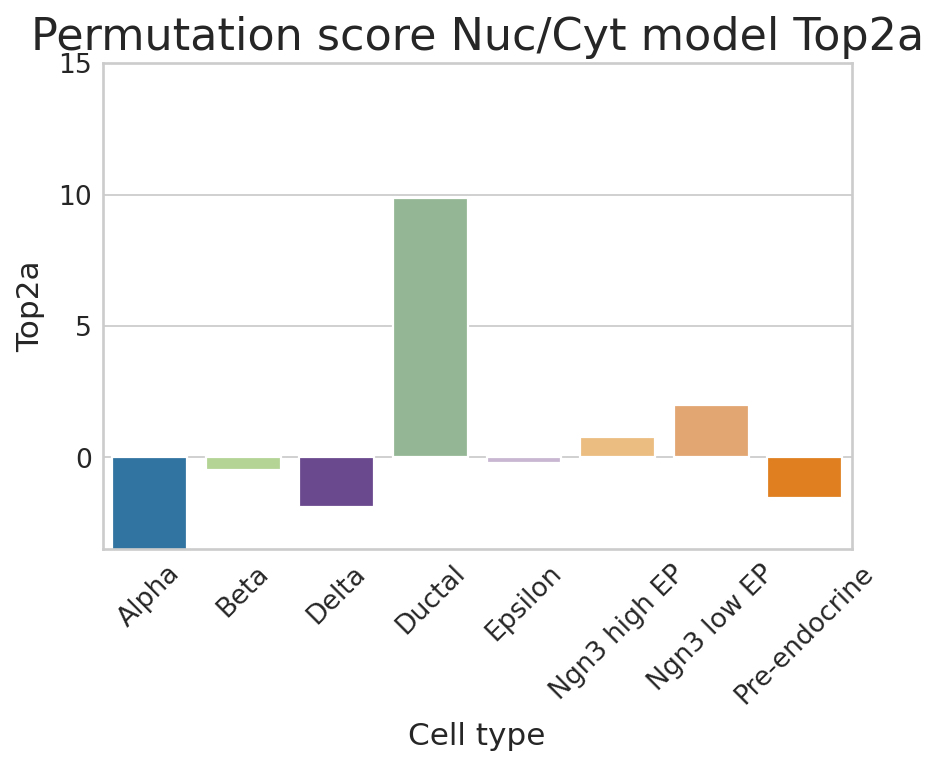

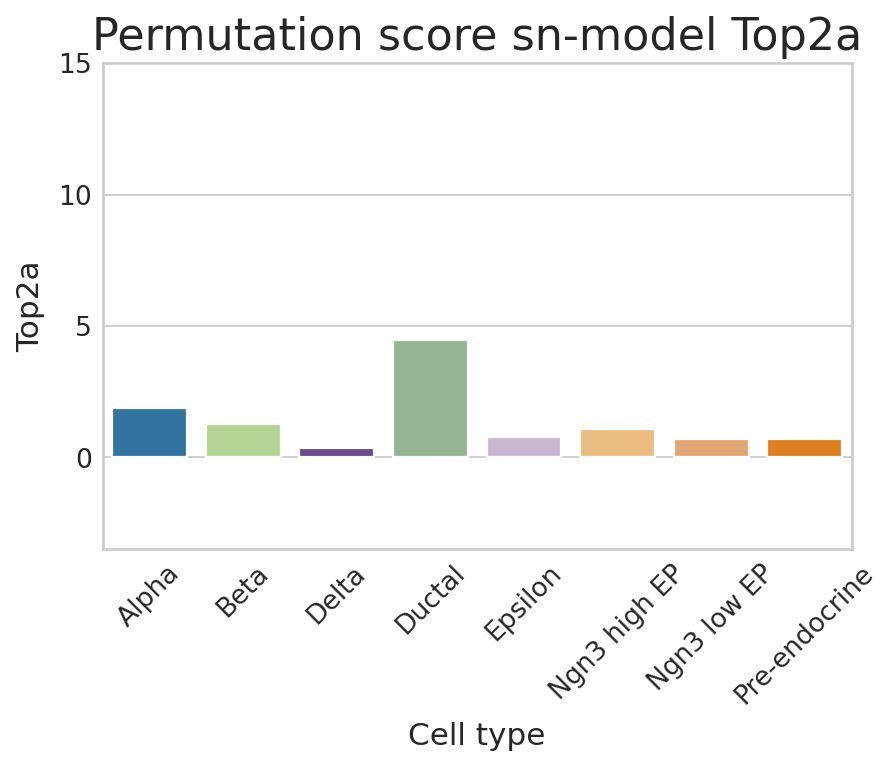

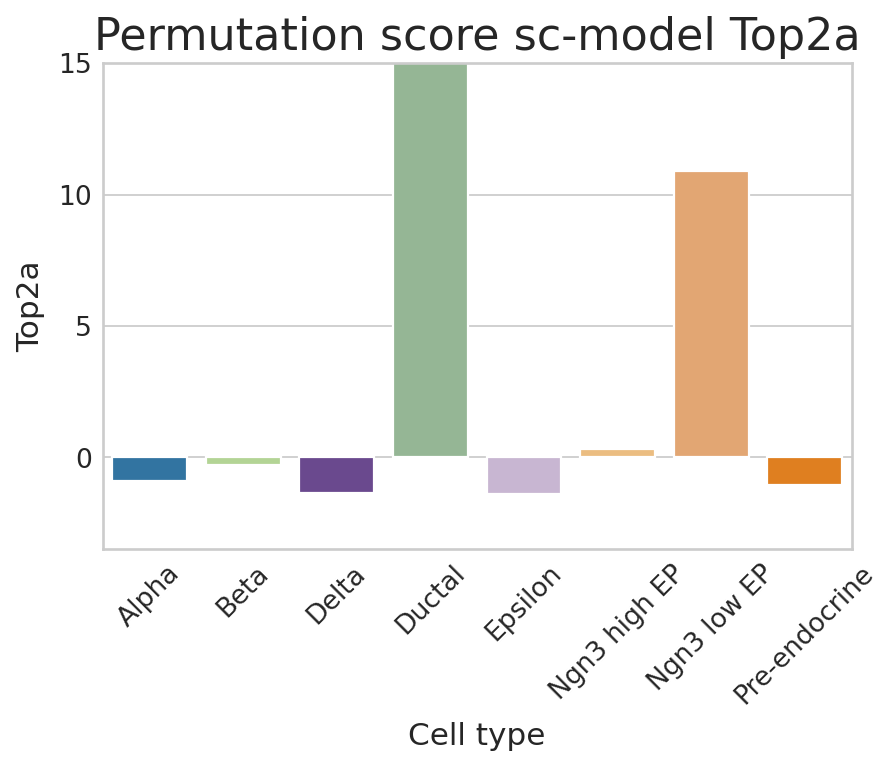

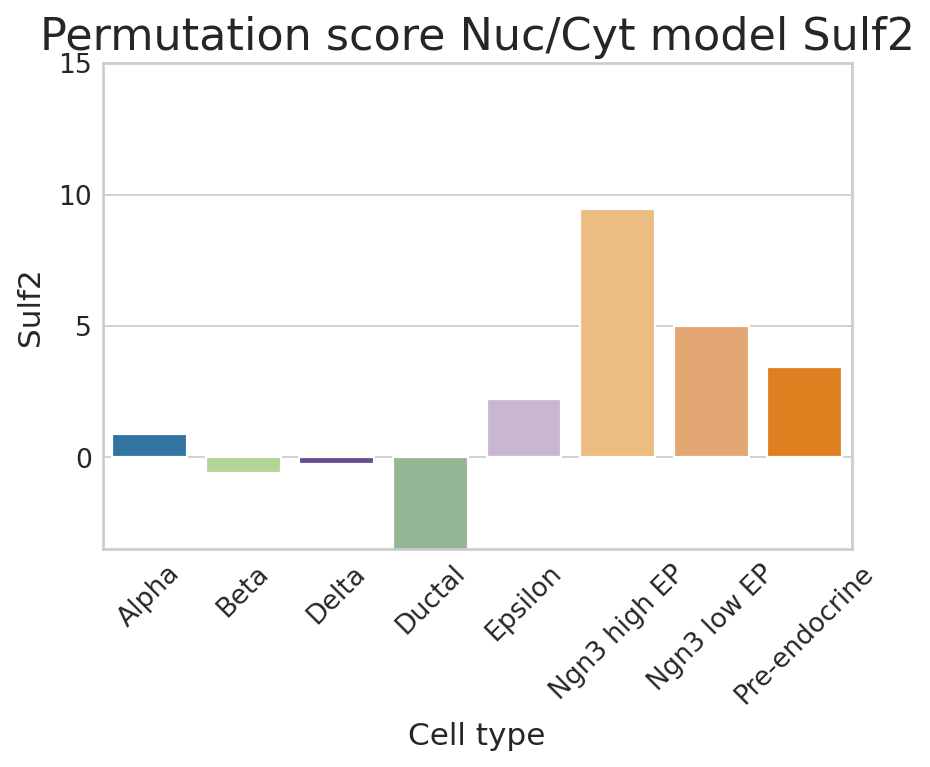

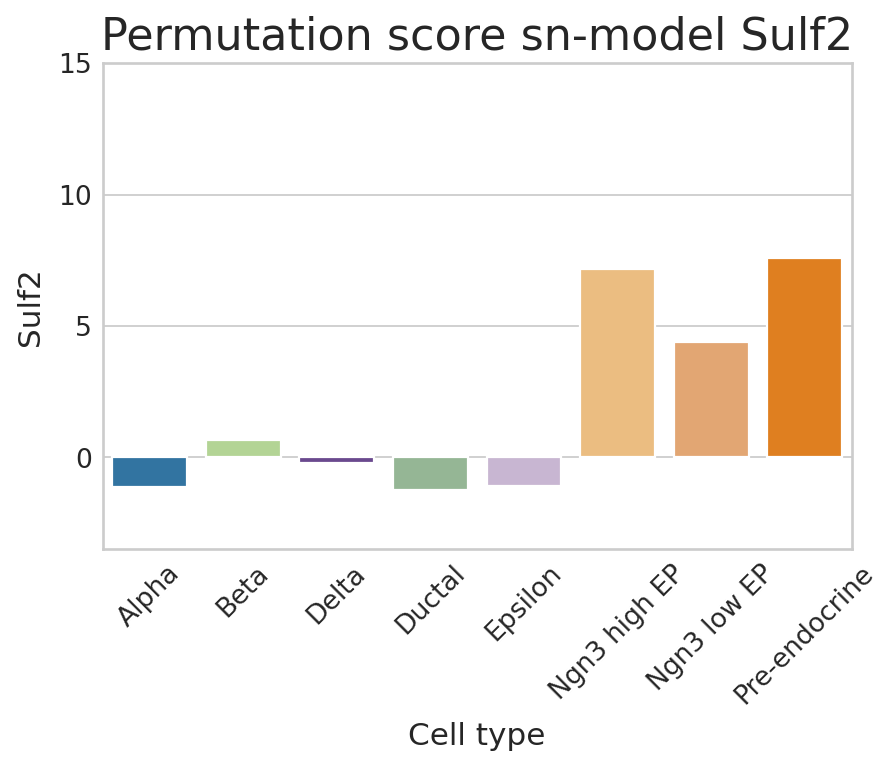

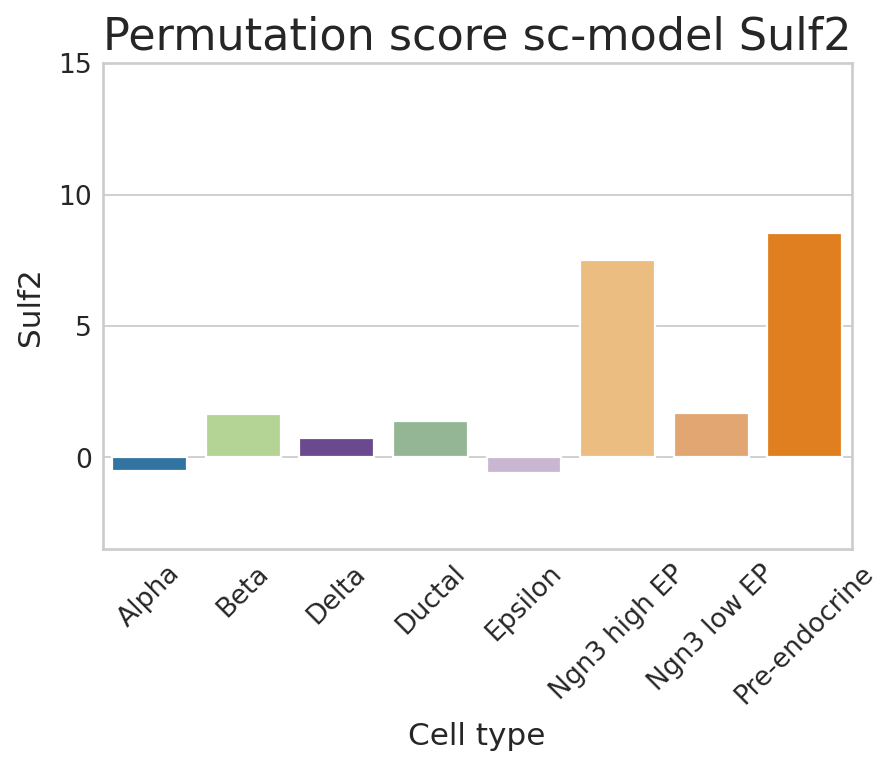

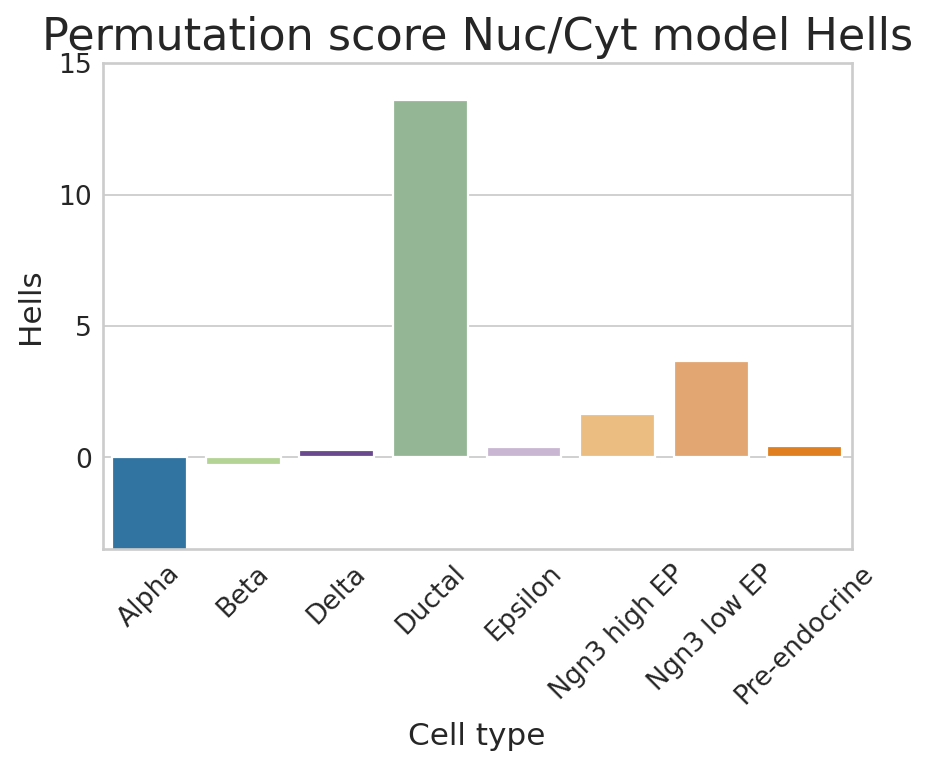

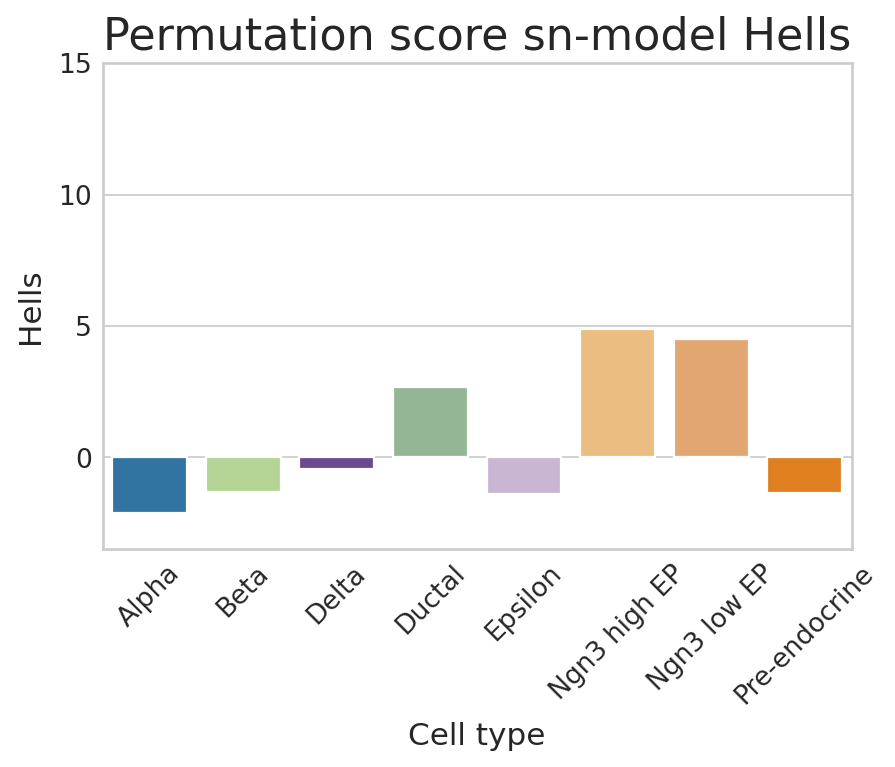

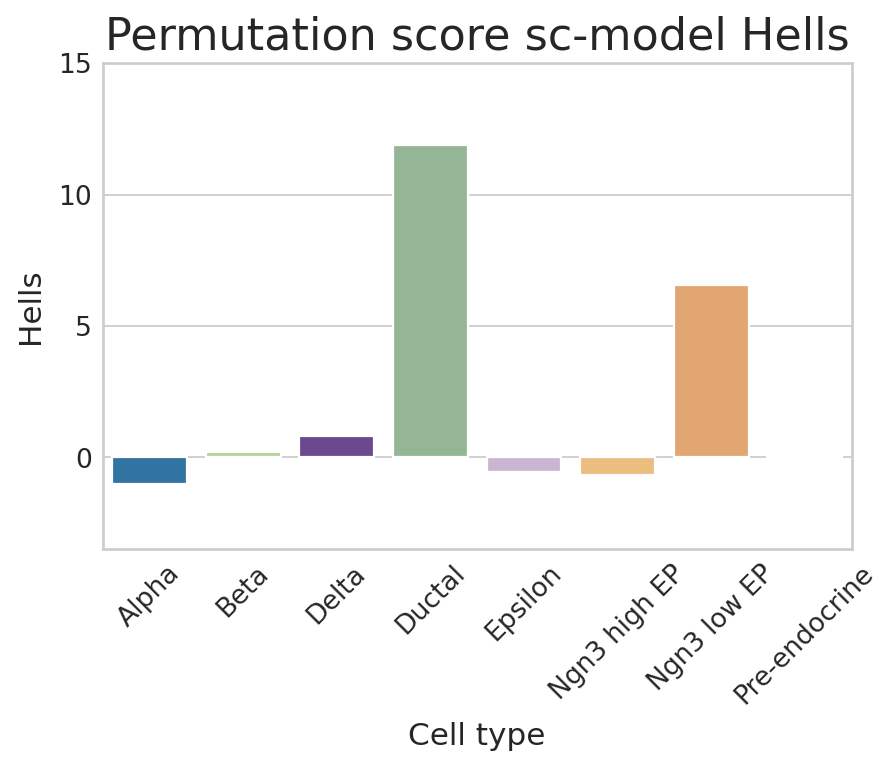

In [36]:
for gene in plot_genes:
    plot_perm_scores(
        adata,
        perm_scores,
        gene,
        "celltype",
        path=FIG_DIR / "permutation_scores" / f"permutation_score_snsc_{gene}_e15.svg",
    )
    plt.title(f"Permutation score Nuc/Cyt model {gene}")
    plt.show()

    plot_perm_scores(
        adata_sn,
        perm_scores_sn,
        gene,
        "celltype",
        path=FIG_DIR / "permutation_scores" / f"permutation_score_sn_{gene}_e15.svg",
    )
    plt.title(f"Permutation score sn-model {gene}")
    plt.show()

    plot_perm_scores(
        adata_sc,
        perm_scores_sc,
        gene,
        "celltype",
        path=FIG_DIR / "permutation_scores" / f"permutation_score_sc_{gene}_e15.svg",
    )
    plt.title(f"Permutation score sc-model {gene}")
    plt.show()